In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=4
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
Mon Feb 26 12:52:53 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   42C    P0    67W / 275W |      0MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:47:00.0 Off

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [3]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/Projects/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/Projects/CaloQVAE/')

In [4]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

import time

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[12:52:56.903] INFO   CaloQVAE                                          Willkommen!
[12:52:56.904] INFO   CaloQVAE                                          Loading configuration.


In [5]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

[12:52:57.431] INFO   numexpr.utils                                     Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[12:52:57.432] INFO   numexpr.utils                                     Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[12:52:57.432] INFO   numexpr.utils                                     NumExpr defaulting to 8 threads.
2024-02-26 12:52:57,850 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[12:52:57.850] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [136]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [137]:


# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/raid/javier/anaconda3/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[17:14:01.135] INFO   data.dataManager                                  Loading Data
[17:14:07.539] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f2ab8f8e850>: 80000 events, 625 batches
[17:14:07.541] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f2ad8444450>: 10000 events, 10 batches
[17:14:07.541] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f2c62349510>: 10000 events, 10 batches
[17:14:09.604] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasPRBMCNN
2024-02-26 17:14:09

Initializing NetworkV3


In [138]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
# dev = torch.device("cuda:0")
dev = "cuda:{0}".format(config.gpu_list[0])

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[17:14:14.625] INFO   wandb                                             Watching
[17:14:14.628] INFO   engine.engineAtlas                                Setting up engine Atlas.
[17:14:14.629] INFO   engine.engineCaloV3                               Setting up engine Calo.
[17:14:14.629] INFO   engine.engine                                     Setting up default engine.


In [139]:
# config=compose(config_name="config.yaml")
config_2=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config_2, mode='disabled')
modelCreator_2 = ModelCreator(cfg=config_2)
dataMgr_2 = DataManager(cfg=config_2)
#initialise data loaders
dataMgr_2.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr_2.pre_processing()

if config_2.model.activation_fct.lower()=="relu":
    modelCreator_2.default_activation_fct=torch.nn.ReLU()
elif config_2.model.activation_fct.lower()=="tanh":
    modelCreator_2.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator_2.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model_2=modelCreator_2.init_model(dataMgr=dataMgr_2)

#create the NN infrastructure
model_2.create_networks()

engine_2=instantiate(config_2.engine, config_2)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine_2._config=config_2
#add dataMgr instance to engine namespace
engine_2.data_mgr=dataMgr_2
#add device instance to engine namespace
engine_2.device=dev    
#instantiate and register optimisation algorithm
engine_2.optimiser = torch.optim.Adam(model_2.parameters(),
                                    lr=config_2.engine.learning_rate)
#add the model instance to the engine namespace
engine_2.model = model_2
# add the modelCreator instance to engine namespace
engine_2.model_creator = modelCreator_2
engine_2.model = engine_2.model.to(dev)

/raid/javier/anaconda3/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[17:14:15.205] INFO   data.dataManager                                  Loading Data
[17:14:21.573] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f2ab88a8b50>: 80000 events, 625 batches
[17:14:21.574] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f2ab8bc9d90>: 10000 events, 10 batches
[17:14:21.575] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f2ae028c1d0>: 10000 events, 10 batches
[17:14:24.701] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasPRBMCNN
2024-02-26 17:14:24

Initializing NetworkV3


In [140]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[17:14:36.136] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f27deb8f190>: 80000 events, 625 batches
[17:14:36.137] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f2a98522dd0>: 10000 events, 10 batches
[17:14:36.137] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f28a535edd0>: 10000 events, 10 batches


In [11]:
###LOAD MODEL

In [12]:
_epoch = 0
if config.load_state:
    print("Loading model...")
    assert config.run_path != 0
    config_string = "_".join(str(i) for i in [config.model.model_type, config.data.data_type, config.tag])
    modelCreator.load_state(config.run_path, dev)
    # _epoch = get_epochs(config.run_path)
    # temp solution to get total number of epochs this model has been trained on
    # fn = create_filenames_dict(config.run_path)
    # _epoch = fn["size"]
    # if config.freeze_vae:
    #     for name, param in engine.model.named_parameters():
    #         if 'decoder' in name or 'encoder' in name:
    #             param.requires_grad = False
    #         print(name, param.requires_grad)
    #     engine.optimiser = torch.optim.Adam(filter(lambda p: p.requires_grad, engine.model.parameters()), lr=config.engine.learning_rate)

In [ ]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])
                    
                    
def load_RBM_state(run_path, device):
        logger.info("Loading RBM state")
        model_loc = run_path
        # Load the dictionary with all tensors mapped to the CPU
        loaded_dict = torch.load(model_loc, map_location=device)
        return loaded_dict
    
# ww = load_RBM_state("/home/javier/Projects/CaloQVAE/outputs/2023-11-20/16-54-48/wandb/latest-run/files/RBM_1_0_weights.pth", dev)

In [10]:
# 150*0.3*0.3

In [223]:
# # apricot-terrain-235 <---- Fully connected NN
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-11-07/19-48-38/wandb/latest-run/files/GumBoltAtlasPRBMFCN_atlas_default_latest.pth"
# modelname = 'apricot-terrain-235'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-11-07/19-48-38/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True


# happy-sun-270 | CNN + voxel pos enc + cond + scaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231201_203858-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231224_160705-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'happy-sun-270'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231224_160705-n9y23yq6/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True

    
# drawn-cosmos-266 | CNN + cond + scaled data
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-24-05/wandb/run-20231224_163015-m4f4z37z/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'drawn-cosmos-266'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-24-05/wandb/run-20231224_163015-m4f4z37z/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True  
    


# # misty-wind-267 | CNN + voxel pos enc JQTM + cond + scaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-37-11/wandb/run-20231224_164009-ti1793rl/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'misty-wind-267'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-37-11/wandb/run-20231224_164009-ti1793rl/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    

    
# # winter-glade-268 | CNN + cond pos enc + scaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-39-27/wandb/run-20231224_163406-p7awkxhk/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'winter-glade-268'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-39-27/wandb/run-20231224_163406-p7awkxhk/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    


# # prime-totem-282 | CNN + voxel pos enc + cond + scaled data
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231201_203858-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-01-08/13-51-41/wandb/run-20240108_135142-2fitsjre/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'prime-totem-282'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-01-08/13-51-41/wandb/run-20240108_135142-2fitsjre/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True  


# # smoldering-candles | CNN + cond + scaled data + no hits
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-13/19-34-51/wandb/run-20240213_193452-zrjorwol/files/GumBoltAtlasPRBMCNNnohits_atlas_default_latest.pth"
# modelname = 'smoldering-candles-302'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-13/19-34-51/wandb/run-20240213_193452-zrjorwol/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True  
    
    
# # generous-elevator | CNN + cond + scaled data + no hits
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-13/18-47-19/wandb/run-20240213_184720-76xrzznn/files/GumBoltAtlasPRBMCNNnohits_atlas_default_latest.pth"
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-13/18-47-19/wandb/run-20240216_200216-76xrzznn/files/GumBoltAtlasPRBMCNNnohits_atlas_default_latest.pth"
# modelname = 'generous-elevator-301'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-13/18-47-19/wandb/run-20240213_184720-76xrzznn/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 
    
    
# # skilled-spaceship-315 | CNN + cond + scaled data + no hits + interpolation 0
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-16/20-05-47/wandb/run-20240216_200548-u9ais1yt/files/GumBoltAtlasPRBMCNNnohits_atlas_default_latest.pth"
# modelname = 'skilled-spaceship-315'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-16/20-05-47/wandb/run-20240216_200548-u9ais1yt/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 
    
    
# # toasty-cherry-310 | CNN + cond + scaled data + hits dec uncond
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-15/22-10-50/wandb/run-20240215_221050-caevb6ld/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'toasty-cherry-310'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-15/22-10-50/wandb/run-20240215_221050-caevb6ld/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 
    
    
# # divine-valentine-309 | CNN + cond + scaled data + dec charm
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-15/17-36-19/wandb/run-20240215_173620-l3i43zja/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'divine-valentine-309'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-15/17-36-19/wandb/run-20240215_173620-l3i43zja/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 


# comic-microwave-334 | CNN + cond + scaled data + exp in MSE loss
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-22/13-29-42/wandb/run-20240222_132943-g7ome9qx/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'comic-microwave-334'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-22/13-29-42/wandb/run-20240222_132943-g7ome9qx/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True 
    

# silver-blaze-338 | CNN + cond + scaled data + exp in MSE loss
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-27/14-14-29/wandb/run-20240227_141430-9ghcd0zi/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
modelname = 'silver-blaze-338'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-27/14-14-29/wandb/run-20240227_141430-9ghcd0zi/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True 

    
    
# # robust-tree-339 | CNN + cond + scaled data + exp in MSE loss
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-27/18-38-25/wandb/run-20240227_183826-y5uczif5/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'robust-tree-339'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-27/18-38-25/wandb/run-20240227_183826-y5uczif5/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 


arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)
print(scaled, reducedata)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
# load_state(model, run_path, dev)
modelCreator.load_state(run_path, dev)
engine.model.eval();

[10:55:19.282] INFO   models.modelCreator                               Loading state
[10:55:19.378] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-02-27/14-14-29/wandb/run-20240227_141430-9ghcd0zi/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth


GumBoltAtlasPRBMCNN
electron-ds2
True False
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [72]:
# honest-blaze-275 | CNN + pions + scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231201_203858-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-11/15-03-26/wandb/run-20231211_150327-vljzh7n3/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'honest-blaze-275'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-11/15-03-26/wandb/run-20231211_150327-vljzh7n3/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True  



arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)
print(scaled, reducedata)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
# load_state(model, run_path, dev)
modelCreator.load_state(run_path, dev)
engine.model.eval();

[14:34:36.861] INFO   models.modelCreator                               Loading state


GumBoltAtlasPRBMCNN
pion1
True False


[14:34:37.084] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2023-12-11/15-03-26/wandb/run-20231211_150327-vljzh7n3/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [143]:
lnZais = engine.model.stater.AIS(30).detach().cpu().item()

In [144]:
lnZrais = engine.model.stater.RAIS(20).detach().cpu().item()
print(lnZais, lnZrais)

7152.71630859375 7154.14453125


In [145]:
lnZais_rdm = engine_2.model.stater.AIS(30).detach().cpu().item()
lnZrais_rdm = engine_2.model.stater.RAIS(20).detach().cpu().item()
print(lnZais_rdm, lnZrais_rdm)

2727.40380859375 2728.11572265625


In [52]:
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, my_model.parameters()), lr=0.001)
engine.model._qpu_sampler.properties["annealing_time_range"]

[0.5, 2000.0]

In [55]:
# lnZais
# for name, param in engine.model.named_parameters():
#     # if 'decoder' in name or 'encoder' in name:
#         # param.requires_grad = False
#     print(name, param.requires_grad)

In [34]:
hfont = {'fontname':'Helvetica'}
ds = {'electron-ds2':'Dataset 2', 'pion1':'Dataset 1: π'}

In [18]:
xx = next(iter(test_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

In [60]:
# xx[1][1].sum()

In [44]:
data_dict["showers"].shape

torch.Size([100000, 6480])

torch.Size([1024, 6480])


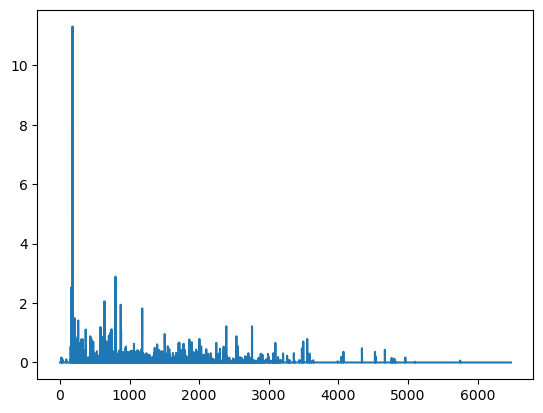

In [19]:
print(in_data.shape)
plt.plot(in_data.cpu().numpy()[3,:])

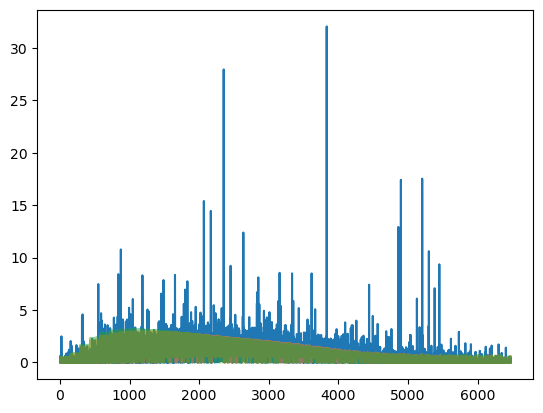

In [182]:
with torch.no_grad():
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    # if reducedata:
        # in_data = engine._reduce(in_data, true_energy, R=R)
    fwd_output = engine.model((in_data, true_energy), True)
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
idx = 2
plt.plot(in_data.cpu().numpy()[idx,:])
plt.plot(fwd_output.output_activations.detach().cpu().numpy()[idx,:], alpha=0.5)
plt.plot(sample_data.detach().cpu().numpy()[idx,:], alpha=0.5)

In [179]:
torch.abs(engine.model._hit_smoothing_dist_mod(fwd_output.output_hits, 500, False) - in_data.sign())


tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 1., 0.],
        ...,
        [1., 1., 0.,  ..., 1., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]], device='cuda:4')

In [16]:
# enIn = torch.cat((in_data, true_energy), dim=1)
# beta, post_logits, post_samples = engine.model.encoder(enIn)
with torch.no_grad():
    # enIn = torch.cat((in_data, true_energy), dim=1)
    # beta, post_logits, post_samples = engine.model.encoder(enIn)
    beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy)
# plt.plot(post_samples[0][0,:].detach().cpu().numpy())
post_samples = torch.cat(post_samples, 1)

In [17]:
# t0 = time.time() outputs = net(x) torch.cuda.current_stream().synchronize() t1 = time.time()

decoder_time = []
for i in range(1):
    # start = time.process_time()
    start = time.time()
    output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
    torch.cuda.current_stream().synchronize()
    t1 = time.time()
    decoder_time.append(t1 - start)
    # decoder_time.append(time.process_time() - start)

In [510]:
print(m, b)

-0.5940070474831793 5.66365279918118


In [514]:
# plt.plot(decoder_time)
# plt.xlabel("trials")
# plt.ylabel("decoder time (s)")
def _just_act_cool(in_data, true_energy):
    beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy)
    post_samples = torch.cat(post_samples, 1)
    output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
    return output_activations

def _shift_energy(in_data, true_energy, m=-0.59400, b=5.663):
    beta, post_logits, post_samples = engine.model.encoder(in_data.to(true_energy.device), true_energy)
    post_samples = torch.cat(post_samples, 1)
    _shifted_energy = true_energy + torch.pow(true_energy, m+1) * torch.exp(torch.tensor([b])).to(true_energy.device)
    output_hits, output_activations = engine.model.decoder(post_samples, _shifted_energy)
    beta = torch.tensor(engine.model._config.model.output_smoothing_fct, dtype=torch.float, device=output_hits.device, requires_grad=False)

    output_activations = engine.model._inference_energy_activation_fct(output_activations) * engine.model._hit_smoothing_dist_mod(output_hits, beta, False)
    return output_activations

In [499]:
# _shift_energy(in_data, true_energy)

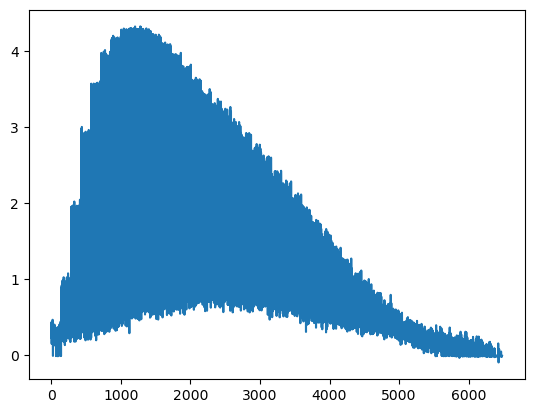

In [20]:
# post_samples = torch.cat([post_samples, true_energy], dim=1)
# post_samples = torch.cat(post_samples,1)
# output_hits, output_activations = engine.model.decoder(post_samples)
output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
plt.plot(output_activations[idx,:].detach().cpu().numpy())


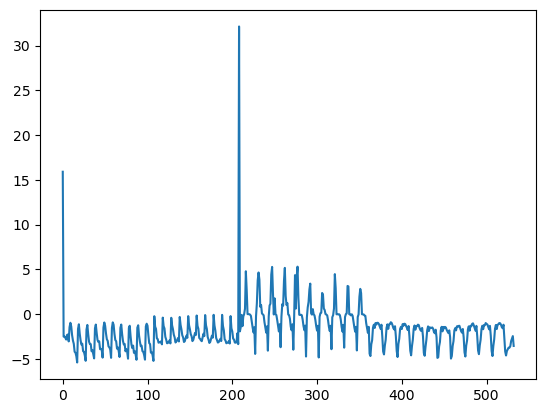

In [26]:
# self._hit_smoothing_dist_mod(output_hits, beta, is_training)
plt.plot(output_hits[1,:].detach().cpu().numpy())
beta = torch.tensor(5, dtype=torch.float, device=output_hits.device, requires_grad=False)

In [68]:
beta = torch.tensor(1, dtype=torch.float, device=output_hits.device, requires_grad=False)

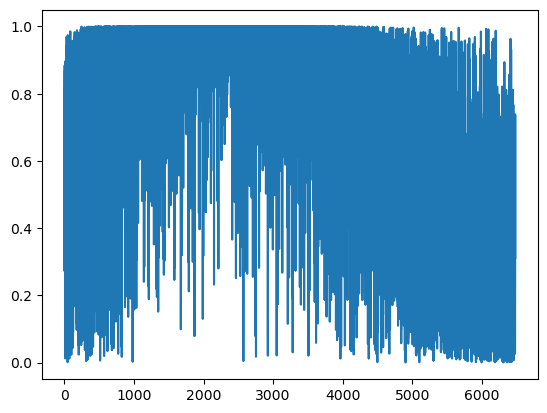

In [69]:
plt.plot(engine.model._hit_smoothing_dist_mod(output_hits, beta, True)[2,:].detach().cpu().numpy())

In [29]:
weight_dict = engine.model.prior.weight_dict

In [30]:
(weight_dict['01']==0).sum()

tensor(259267, device='cuda:0')

In [39]:
# fwd_output.output_activations.shape

In [207]:
directory_path = f'/home/javier/Projects/CaloQVAE/figs/{modelname}'
if not os.path.isdir(directory_path):
    os.mkdir(directory_path) 
    print(modelname)
else:
    pass

robust-tree-339


In [13]:
beta, beta_list, rbm_energy_list, dwave_energy_list, thrsh_met = engine.model.find_beta(num_reads=128, beta_init=4.0, lr=0.01, num_epochs = 20, delta = 4.0, method = 2, TOL=True, const = 1.0, adaptive = True)

[12:21:03.183] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.0
[12:21:05.986] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.5329407874522865
[12:21:08.159] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 4.426763574992807
[12:21:10.342] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 4.375134765108521
[12:21:12.448] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 4.334797868970208
[12:21:13.973] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 4.405261306158848
[12:21:15.470] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 6: beta = 4.358790003418545


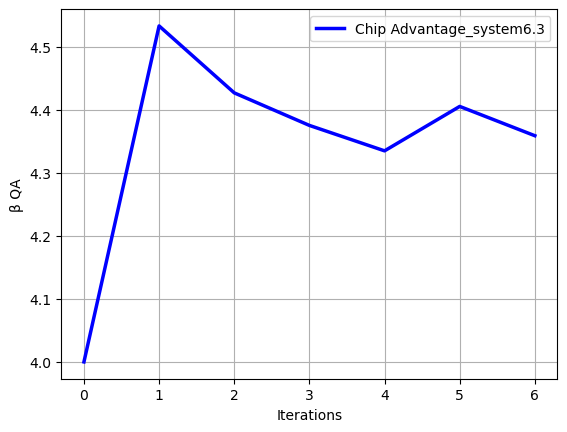

In [14]:
plt.plot(beta_list, linewidth=2.5, color="b" )
plt.xlabel("Iterations")
plt.ylabel("β QA")
plt.legend([f'Chip {engine.model._qpu_sampler.properties["chip_id"]}'])
# plt.title(f'{ds[part]}')
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/beta_QA_{engine.model._qpu_sampler.properties["chip_id"]}_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
# engine.model.eval();
# (engine.model.prior._weight_dict['01'] == 0).sum(axis=1)

In [30]:
np.round(beta, 2)

3.81

In [15]:
Hoffset = -(sum([engine.model.prior.bias_dict[key].sum().detach().cpu().item() for key in engine.model.prior.bias_dict.keys()])/2 + sum([engine.model.prior.weight_dict[key].sum().detach().cpu().item() for key in engine.model.prior.weight_dict.keys()])/4)


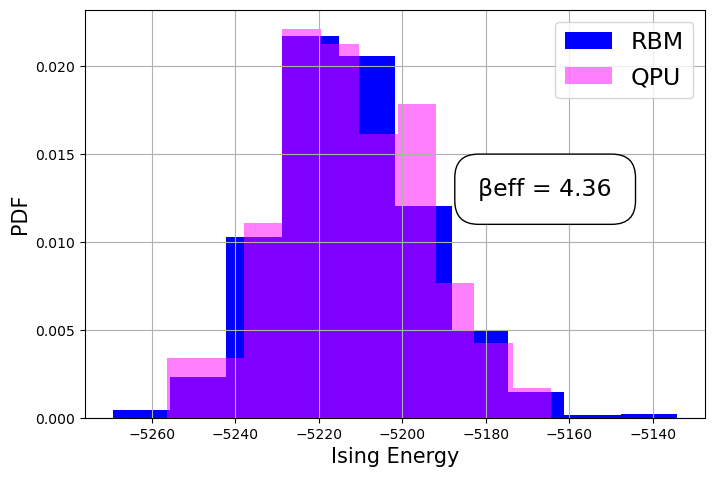

1024


In [16]:
plt.figure(figsize=(8,6))
plt.hist(rbm_energy_list[-1] + Hoffset, density=True, color="b")
plt.hist(dwave_energy_list[-1] + Hoffset, density=True, fc=(1, 0, 1, 0.5))
plt.xlabel("Ising Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.legend(["RBM", "QPU"], fontsize=17)
# plt.title(f'ln(Z)[AIS] = {np.round(Zais)}, ln(Z)[RAIS] = {np.round(Zrais)}')
plt.figtext(0.7, 0.6, f'βeff = {np.round(beta, 2)}', ha='center', va='top', fontsize=17, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
plt.subplots_adjust(bottom=0.2)
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/Ising_energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
print(len(rbm_energy_list[-1]))

In [18]:
from utils.hists.RBMenergyHist import generate_rbm_energy_hist

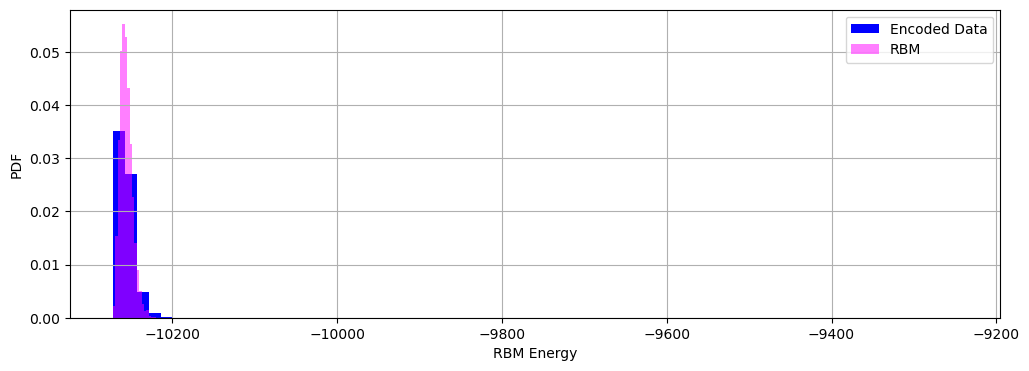

In [151]:
generate_rbm_energy_hist(engine, config.model, val_loader, False)

In [41]:
# Encoded data and RBM
encoded_data.shape

torch.Size([10000, 2048])

In [150]:
partition_size=config.model.n_latent_nodes
energy_encoded_data = []

engine.model.eval()
with torch.no_grad():
    for xx in val_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        # enIn = torch.cat((in_data, true_energy), dim=1)
        # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
        energy_encoded_data.append(post_samples_energy.detach().cpu())

energy_encoded_data = torch.cat(energy_encoded_data, dim=0)

In [21]:

partition_size=config.model.n_latent_nodes
encoded_data = []
energy_encoded_data = []

encoded_data_rdm = []
energy_encoded_data_rdm = []
engine.model.eval()
engine_2.model.eval()
with torch.no_grad():
    for xx in val_loader:
    # for xx in train_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        # enIn = torch.cat((in_data, true_energy), dim=1)
        # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
        encoded_data.append(post_samples.detach().cpu())
        energy_encoded_data.append(post_samples_energy.detach().cpu())
        
        #Rdm model
        # enIn = torch.cat((in_data, true_energy), dim=1)
        # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        beta, post_logits, post_samples = engine_2.model.encoder(in_data, true_energy, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine_2.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
        encoded_data_rdm.append(post_samples.detach().cpu())
        energy_encoded_data_rdm.append(post_samples_energy.detach().cpu())

encoded_data = torch.cat(encoded_data, dim=0)
energy_encoded_data = torch.cat(energy_encoded_data, dim=0)
        
encoded_data_rdm = torch.cat(encoded_data_rdm, dim=0)
energy_encoded_data_rdm = torch.cat(energy_encoded_data_rdm, dim=0)

p1,p2,p3,p4 = post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], \
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size]

energy_rbm_data = []
energy_rbm_rdm_data = []
with torch.no_grad():
    for i in range(10):
        # if i == 0:
            # p1, p2, p3, p4 = engine.model.stater.block_gibbs_sampling_ais(1.0)
        # else:
            # p1, p2, p3, p4 = engine.model.stater.block_gibbs_sampling_ais(1.0, p1, p2, p3, p4)
        p1, p2, p3, p4 = engine.model.sampler.block_gibbs_sampling()
        rbm_samples_energy = engine.model.stater.energy_samples(p1, p2, p3, p4, 1.0)
        energy_rbm_data.append(rbm_samples_energy.detach().cpu())
        
        if i == 0:
            p1_r, p2_r, p3_r, p4_r = engine_2.model.stater.block_gibbs_sampling_ais(1.0)
        else:
            p1_r, p2_r, p3_r, p4_r = engine_2.model.stater.block_gibbs_sampling_ais(1.0, p1_r, p2_r, p3_r, p4_r)
        rbm_rdm_samples_energy = engine_2.model.stater.energy_samples(p1_r, p2_r, p3_r, p4_r, 1.0)
        energy_rbm_rdm_data.append(rbm_rdm_samples_energy.detach().cpu())
    
energy_rbm_data = torch.cat(energy_rbm_data, dim=0)
energy_rbm_rdm_data = torch.cat(energy_rbm_rdm_data, dim=0)

NameError: name 'engine_2' is not defined

In [153]:
print("LL of trained model", -energy_encoded_data.mean() - lnZais)
print("LL of trained model. Gibbs samples data", -energy_rbm_data.mean() - lnZais)
print("LL of rdm model", -energy_encoded_data_rdm.mean() - lnZrais_rdm)
print("LL of rdm model. Gibbs Samples data", -energy_rbm_rdm_data.mean() - lnZrais_rdm)
print(lnZais, lnZais_rdm)

LL of trained model tensor(3103.5298)
LL of trained model. Gibbs samples data tensor(3103.1372)
LL of rdm model tensor(-2679.0876)
LL of rdm model. Gibbs Samples data tensor(-749.6685)
7152.71630859375 2727.40380859375


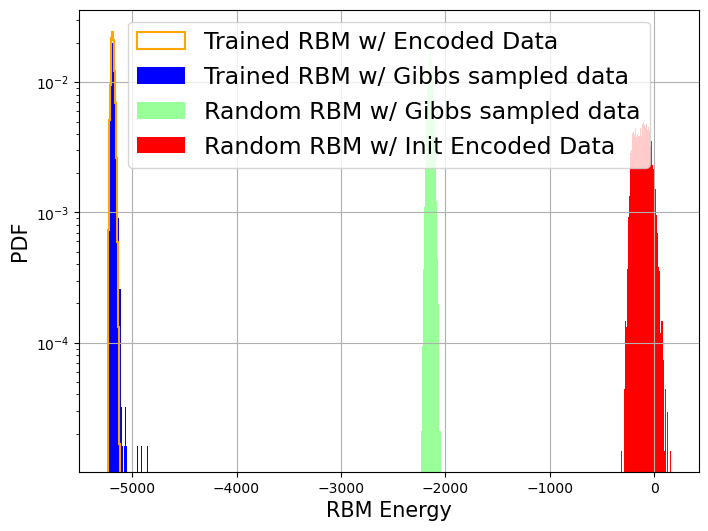

In [93]:
plt.figure(figsize=(8,6))
plt.hist(energy_encoded_data.numpy(), bins=70, linewidth=2.5, color="b", density=True, log=True)
plt.hist(energy_rbm_data.numpy(), bins=20, color="orange", density=True, fc=(1, 0, 1, 0.5), histtype='step', linewidth=1.5)
plt.hist(energy_rbm_rdm_data.numpy(), bins=20, linewidth=2.5, color="cyan", density=True, fc=(0.5, 1.0, 0.5, 0.8))
plt.hist(energy_encoded_data_rdm.numpy(), bins=70, linewidth=2.5, color="r", density=True)

plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.legend(["Trained RBM w/ Encoded Data", "Trained RBM w/ Gibbs sampled data", "Random RBM w/ Gibbs sampled data", "Random RBM w/ Init Encoded Data"], fontsize=17)
# plt.title(f'ln(Z)[AIS] = {np.round(Zais)}, ln(Z)[RAIS] = {np.round(Zrais)}')
# plt.title(f'LL(trained) = {np.round(-energy_encoded_data.mean() - lnZais)}, LL(Rdm) = {np.round(-energy_encoded_data_rdm.mean() - lnZrais_rdm)} \n \
        # LL(trained RBM data) = {np.round(-energy_rbm_data.mean() - lnZais)}, LL(Rdm RBM data) = {np.round(-energy_rbm_rdm_data.mean() - lnZrais_rdm)}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/RBM_energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

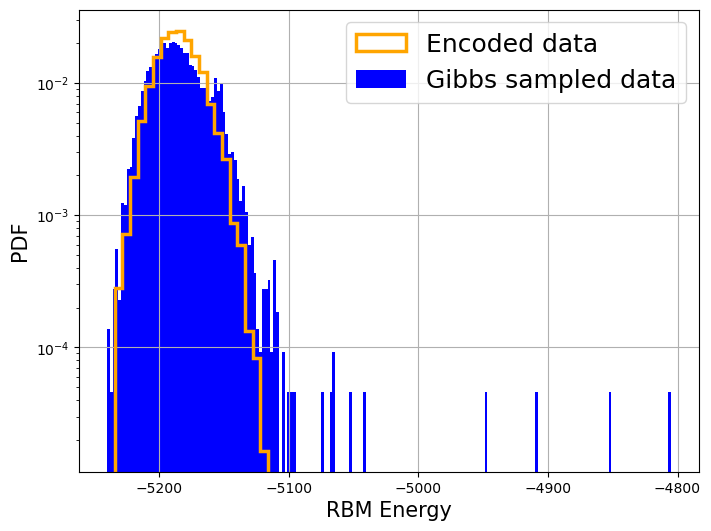

In [94]:
plt.figure(figsize=(8,6))
plt.hist(energy_encoded_data.numpy(), bins=200, linewidth=2.5, color="b", density=True, log=True)
plt.hist(energy_rbm_data.numpy(), bins=20, color="orange", density=True, fc=(1, 0, 1, 0.5), log=True, histtype='step', linewidth=2.5)
# plt.hist(energy_rbm_rdm_data.numpy(), bins=20, linewidth=2.5, color="cyan", density=True, fc=(0.5, 1.0, 0.5, 0.8))
# plt.hist(energy_encoded_data_rdm.numpy(), bins=70, linewidth=2.5, color="r", density=True)

plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.legend(["Encoded data", "Gibbs sampled data", "Init RBM", "Init Encoded Data"], fontsize=18)
# plt.title(f'ln(Z)[AIS] = {np.round(Zais)}, ln(Z)[RAIS] = {np.round(Zrais)}')
# plt.title(f'LL(trained) = {np.round(-energy_encoded_data.mean() - lnZais)}, LL(Rdm) = {np.round(-energy_encoded_data_rdm.mean() - lnZrais_rdm)} \n \
        # LL(trained RBM data) = {np.round(-energy_rbm_data.mean() - lnZais)}, LL(Rdm RBM data) = {np.round(-energy_rbm_rdm_data.mean() - lnZrais_rdm)}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/RBM_energy_2_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [551]:
# Sparsity and Energy
# beta
# _just_act_cool(in_data, true_energy)
# _shift_energy(in_data, true_energy)

In [224]:
# en_labels = []

xtarget_samples = []
xrecon_samples = []
xgen_samples = []
xgen_samples_qpu = []

# xrecon_samples_2 = []

# labelstarget_samples = []
# labelsrecon_samples = []
entarget_samples = []
with torch.no_grad():
    for xx in val_loader:
    # for xx in train_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        # print(in_data.shape)
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        fwd_output = engine.model((in_data, true_energy), False)
        # fwd_just_act = _just_act_cool(in_data, true_energy)
        # fwd_energy_shift = _shift_energy(in_data, true_energy)
        if reducedata:
            in_data = engine._reduceinv(in_data, true_energy, R=R)
            recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
        elif scaled:
            in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
            recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
            # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_just_act.detach().cpu().numpy()))
            # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_energy_shift.detach().cpu().numpy()))
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
            # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
            # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
        else:
            in_data = in_data.detach().cpu()*1000
            recon_data = fwd_output.output_activations.detach().cpu()*1000
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
            sample_data = sample_data.detach().cpu()*1000


        xtarget_samples.append(in_data.detach().cpu())
        xrecon_samples.append( recon_data.detach().cpu())
        xgen_samples.append( sample_data.detach().cpu())
        # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
        entarget_samples.append(true_energy.detach().cpu())

        # xrecon_samples_2.append( recon_data_2.detach().cpu())
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
# xgen_samples_qpu = torch.cat(xgen_samples_qpu, dim=0)
entarget_samples = torch.cat(entarget_samples, dim=0)

# xrecon_samples_2 = torch.cat(xrecon_samples_2, dim=0)

In [225]:
(xgen_samples.sum(dim=0) == 0).sum()
(xrecon_samples.sum(dim=0) == 0).sum()
# (xtarget_samples.sum(dim=0) == 0).sum()
# print((xgen_samples.sum(dim=0) == 0).nonzero(as_tuple=True))
# print((xrecon_samples.sum(dim=0) == 0).nonzero(as_tuple=True))

tensor(0)

In [173]:
# Random RBM
# engine.model.sampler._prbm._bias_dict = load_RBM_state(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-21/13-09-06/wandb/latest-run/files/RBM/RBM_1_9_biases.pth', dev)
# engine.model.sampler._prbm._weight_dict = load_RBM_state(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-21/13-09-06/wandb/latest-run/files/RBM/RBM_1_9_weights.pth', dev)
engine.model.sampler._prbm._bias_dict = engine_2.model.sampler._prbm._bias_dict
engine.model.sampler._prbm._weight_dict = engine_2.model.sampler._prbm._weight_dict
# en_labels = []

xtarget_samples = []
xrecon_samples = []
xgen_samples = []
xgen_samples_qpu = []

# labelstarget_samples = []
# labelsrecon_samples = []
entarget_samples = []
with torch.no_grad():
    for xx in val_loader:
    # for xx in train_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        fwd_output = engine.model((in_data, true_energy), False)
        if reducedata:
            in_data = engine._reduceinv(in_data, true_energy, R=R)
            recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
        elif scaled:
            in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
            recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
            # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
            # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
        else:
            in_data = in_data.detach().cpu()*1000
            recon_data = fwd_output.output_activations.detach().cpu()*1000
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
            sample_data = sample_data.detach().cpu()*1000

        # xrecon_samples.append( torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy())) )
    #     if engine._config.engine.cl_lambda:
    #         labelsrecon_samples.append(fwd_output.labels.detach().cpu())
    #         labelstarget_samples.append( nn.functional.one_hot(true_energy.divide(256).log2().to(torch.int64), num_classes=15).squeeze(1).to(torch.float).detach().cpu() )

    #         en_labels.append(true_energy.detach().cpu())

        xtarget_samples.append(in_data.detach().cpu())
        xrecon_samples.append( recon_data.detach().cpu())
        xgen_samples.append( sample_data.detach().cpu())
        # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
        entarget_samples.append(true_energy.detach().cpu())

        # xtarget_samples.append( torch.tensor(engine._data_mgr.inv_transform(xx[0][0].detach().cpu().numpy())) )
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
# xgen_samples_qpu = torch.cat(xgen_samples_qpu, dim=0)
entarget_samples = torch.cat(entarget_samples, dim=0)

# if engine._config.engine.cl_lambda:
#     labelstarget_samples = torch.cat(labelstarget_samples, dim=0)
#     labelsrecon_samples = torch.cat(labelsrecon_samples, dim=0)
#     en_labels = torch.cat(en_labels, dim=0)

#     lhat = torch.argmax(nn.Sigmoid()(labelsrecon_samples), dim=1).numpy()
#     l = torch.argmax(labelstarget_samples, dim=1).numpy()



In [44]:
print("mean qpu time", np.mean([engine._model.sampling_time_qpu[i][0] for i in range(9)]), np.std([engine._model.sampling_time_qpu[i][0] for i in range(9)]))
print("mean gpu time", np.mean([engine._model.sampling_time_gpu[i][0] for i in range(9)]), np.std([engine._model.sampling_time_gpu[i][0] for i in range(9)]))
print("mean gpu time/mean qpu time", np.mean([engine._model.sampling_time_gpu[i][0] for i in range(9)])/np.mean([engine._model.sampling_time_qpu[i][0] for i in range(9)]))


mean qpu time 0.07484855213099056 0.0008544467559427857
mean gpu time 1.9804112023363512 0.034705626437319705
mean gpu time/mean qpu time 26.45891130760263


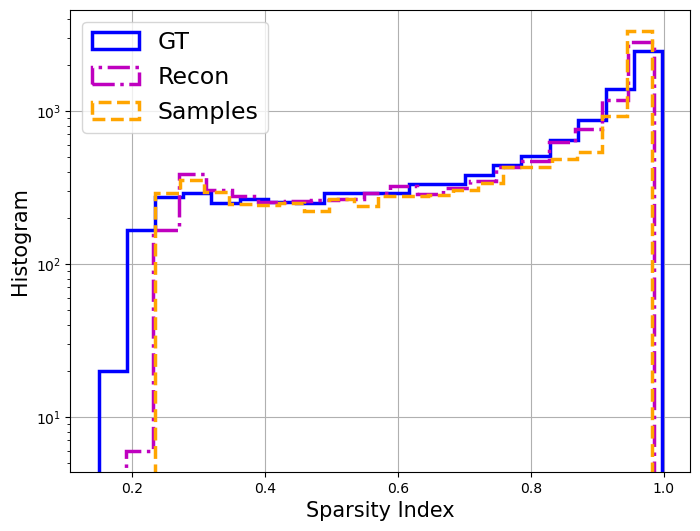

In [208]:
plt.figure(figsize=(8,6))
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(((xgen_samples_qpu == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
plt.xlabel("Sparsity Index", fontsize=15)
plt.ylabel("Histogram", fontsize=15)
plt.legend(["GT", "Recon", "Samples", "Sample /w QPU"], fontsize=17)
# plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

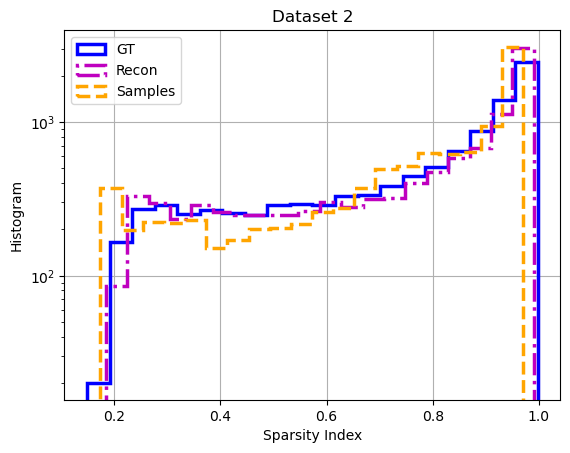

In [174]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(((xgen_samples_qpu == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
plt.xlabel("Sparsity Index")
plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Samples", "Sample /w QPU"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_RDM_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [36]:
# idxPrev = 0
# # for i,idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i, idx in enumerate([16*9*i for i in range(1,5)]):
# # for i,idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
#     l = idx - idxPrev
#     print('Layer ', i, l, ' voxels')
#     plt.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
#     plt.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
#     plt.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
#     plt.xlabel("Sparsity Index")
#     plt.ylabel("Histogram")
#     plt.legend(["GT", "Recon", "Sample"])
#     plt.title(f'{part} Layer {i}')
#     # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
#     plt.show()
#     idxPrev = idx

<Figure size 800x600 with 0 Axes>

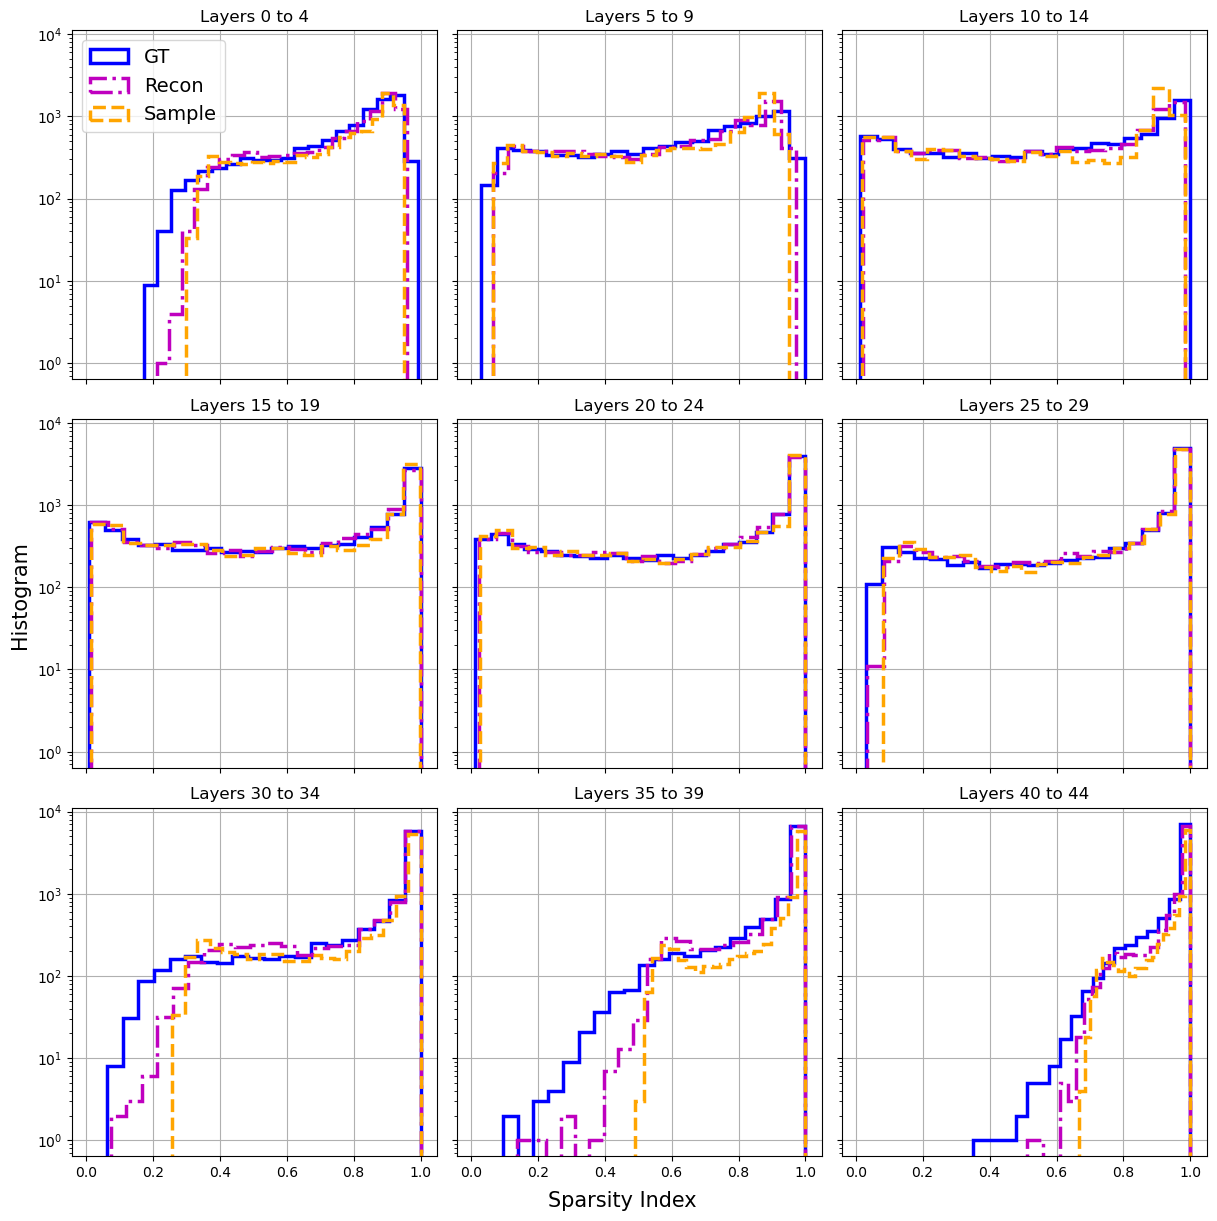

In [209]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=True, tight_layout=True)
fig.text(0.5, -0.01, 'Sparsity Index', ha='center', fontsize=15)
fig.text(-0.01, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    ax.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(),  bins=20, log=True, histtype='step', linewidth=2.5, color="b")
    ax.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
    # ax.hist(((xgen_samples_qpu[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
    # ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], title=f'{ds[part]}')
    if i == 0:
        ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=14)
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}', fontsize=12)

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


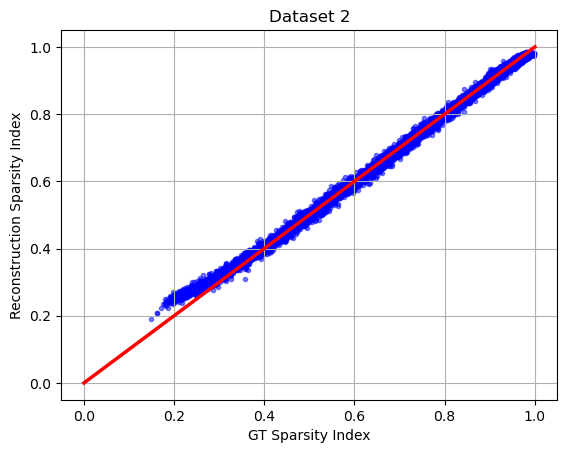

In [210]:
plt.scatter(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), ((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(),  marker='.', alpha=.5, color="b")
plt.plot([0,1],[0,1], c='red', lw=2.5)
plt.xlabel('GT Sparsity Index')
plt.ylabel('Reconstruction Sparsity Index')
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [160]:
# np.unique(entarget_samples)

In [194]:
# tmp = entarget_samples == np.unique(entarget_samples)[3]
# idxEnFilter = (tmp == True).nonzero(as_tuple=True)[0]
# len(idxEnFilter)
# ((xtarget_samples - xrecon_samples).sum(dim=1)/1000).mean()

In [229]:
E_right = 20000
E_left = 10000
tmp = (entarget_samples < E_right) * (entarget_samples > E_left)
idxEnFilter = (tmp == True).nonzero(as_tuple=True)[0]
len(idxEnFilter)

994

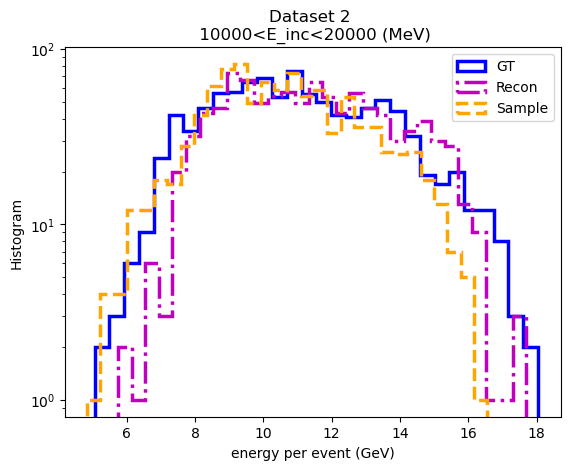

In [230]:
plt.hist(xtarget_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(xrecon_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(xgen_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(xgen_samples_qpu[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")

plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
plt.title(f'{ds[part]} \n {E_left}<E_inc<{E_right} (MeV)')
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_slice_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

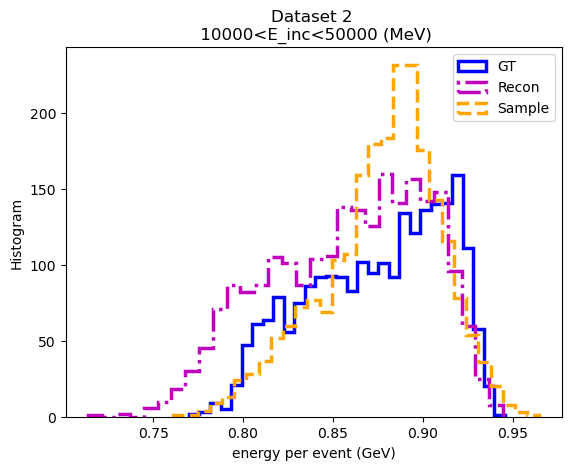

In [194]:
plt.hist((xtarget_samples[idxEnFilter,:]==0).sum(dim=1).numpy()/xtarget_samples.shape[1], bins=30, log=False, histtype='step', linewidth=2.5, color="b")
plt.hist((xrecon_samples[idxEnFilter,:]==0).sum(dim=1).numpy()/xtarget_samples.shape[1], bins=30, log=False, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
# plt.hist((xrecon_samples_2[idxEnFilter,:]==0).sum(dim=1).numpy()/xtarget_samples.shape[1], bins=30, log=False, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist((xgen_samples[idxEnFilter,:]==0).sum(dim=1).numpy()/xtarget_samples.shape[1], bins=30, log=False, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(xgen_samples_qpu[idxEnFilter,:].sum(dim=1).numpy()/xtarget_samples.shape[1], bins=30, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")

plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
plt.title(f'{ds[part]} \n {E_left}<E_inc<{E_right} (MeV)')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_slice_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

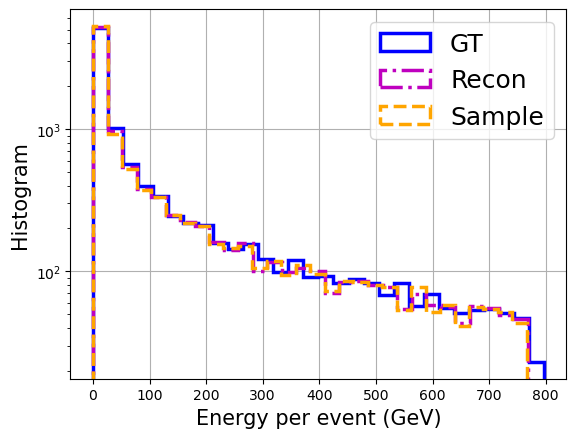

torch.Size([10000, 6480])


In [214]:
plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(xgen_samples_qpu.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="green", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="b")
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
plt.xlabel("Energy per event (GeV)", fontsize=15)
# plt.xscale('log')

plt.ylabel("Histogram", fontsize=15)
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=18)
# plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
print(xgen_samples.shape)

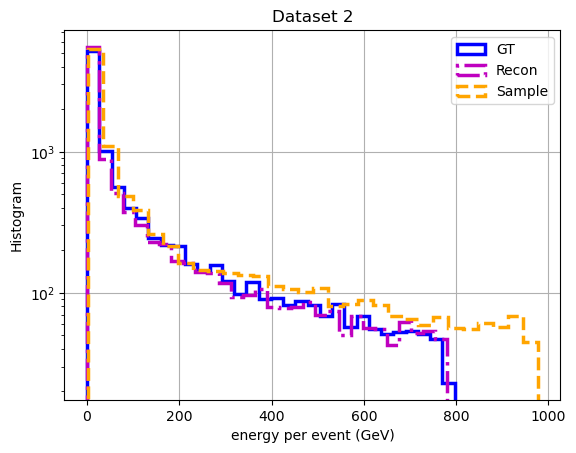

torch.Size([10000, 6480])


In [175]:
plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(xgen_samples_qpu.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="green", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="b")
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_RDM_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
print(xgen_samples.shape)

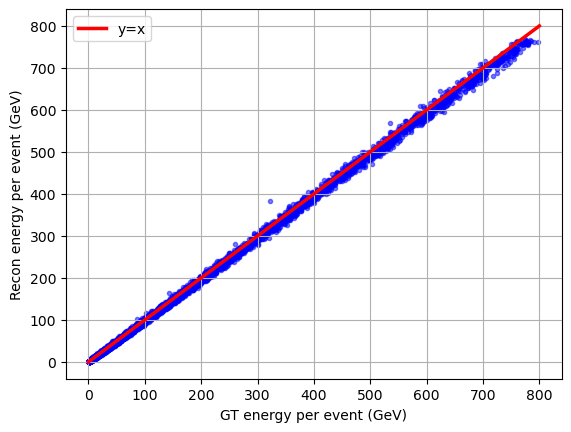

In [215]:
plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
plt.plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# plt.plot([0,20],[0,20], c='red', lw=2)
# axes[0,1].set_xlabel("GT energy per event (GeV)")
plt.legend()
plt.grid("True")
plt.xlabel("GT energy per event (GeV)")
plt.ylabel("Recon energy per event (GeV)")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

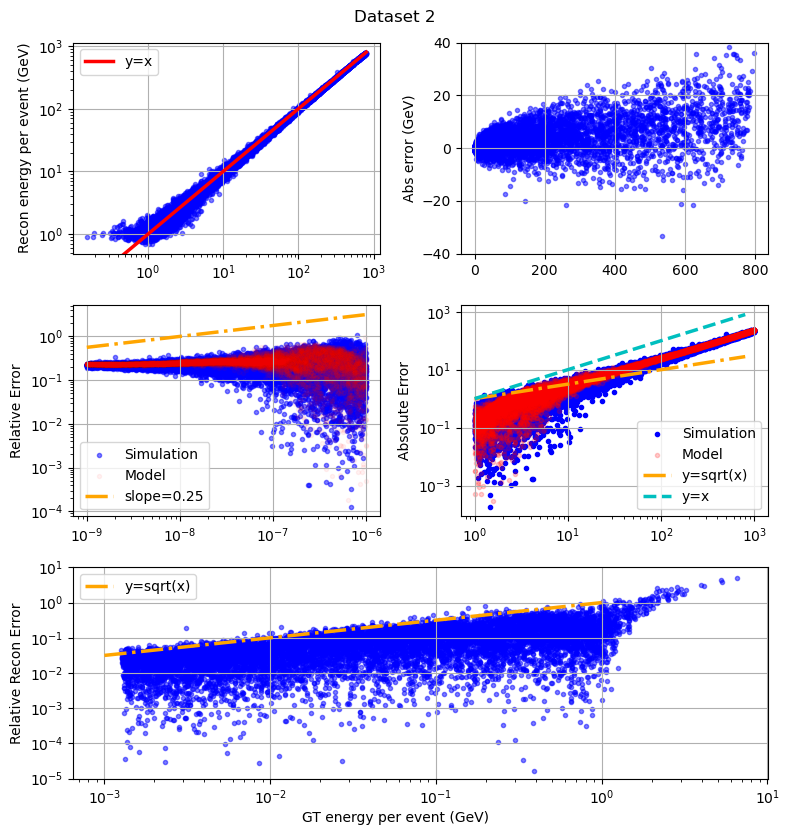

In [216]:
fig, axes = plt.subplots(3,2, figsize=(8,8), tight_layout=True)
fig.text(0.5, 0.0, 'GT energy per event (GeV)', ha='center')
fig.text(0.5, 1.0, f'{ds[part]}', ha='center', fontsize=12)

axes[0,0].scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
axes[0,0].plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# axes[0,0].plot([0,3800],[0,3800], c='red', lw=2.5, label='y=x')
axes[0,0].set_ylabel("Recon energy per event (GeV)")
axes[0,0].legend()
axes[0,0].grid("True")
axes[0,0].set_yscale('log')
axes[0,0].set_xscale('log')

axes[0,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, (xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/1000, marker='.', alpha=.5, color="b")
# plt.plot([0,20],[0,20], c='red', lw=2)
# axes[0,1].set_xlabel("GT energy per event (GeV)")
axes[0,1].set_ylabel("Abs error (GeV)")
axes[0,1].set_ylim([-40,40])
# axes[0,1].legend()
# axes[0,1].set_yscale('log')
axes[0,1].grid("True")

# axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
# axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
axes[1,0].scatter(1/entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
axes[1,0].scatter(1/entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
axes[1,0].plot([1e-9,1e-6],np.power([1e-9,1e-6],0.25)*np.power(10,2.0), c='orange', lw=2.5, label='slope=0.25', linestyle="dashdot")
axes[1,0].grid("True")
axes[1,0].set_yscale('log')
axes[1,0].set_xscale('log')
axes[1,0].legend()
axes[1,0].set_ylabel("Relative Error")

# axes[1,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, np.abs(xtarget_samples.sum(dim=1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.5, color="blue")
axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xtarget_samples.sum(dim=1).numpy()/1000), marker='.', alpha=1, color="blue", label="Simulation")
axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.2, color="red", label="Model")
axes[1,1].plot([1,800],np.sqrt([1,800]), c='orange', lw=2.5, label='y=sqrt(x)', linestyle="dashdot")
axes[1,1].plot([1,800],[1,800], c='c', lw=2.5, label='y=x', linestyle="dashed")
# axes[1,1].set_title(f'{ds[part]}')
axes[1,1].grid("True")
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].set_ylabel("Absolute Error")
axes[1,1].legend()


# Merge the first row's axes
gs = axes[2, 0].get_gridspec()
for ax in axes[2, :]:
    ax.remove()
ax_big = fig.add_subplot(gs[2, :])
ax_big.scatter(1/(xtarget_samples.sum(dim=1).numpy()/1000), np.abs(xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/(xtarget_samples.sum(dim=1).numpy()+1e-3), marker='.', alpha=.5, color="blue")
# axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
# axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
# axes[1,0].set_title(f'{ds[part]}')
ax_big.plot([1e-3,1e0],np.sqrt([1e-3,1e-0])*np.power(1,3.5), c='orange', lw=2.5, label='y=sqrt(x)', linestyle="dashdot")
# axes[1,1].plot([1e-9,1e-6],np.linspace(1e-9,1e-6)*np.power(10,3.5), c='c', lw=2.5, label='y=x', linestyle="dashed")
ax_big.grid("True")
ax_big.set_yscale('log')
ax_big.set_xscale('log')
ax_big.legend()
ax_big.set_ylim([1e-5,1e1])
ax_big.set_yticks([1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax_big.set_ylabel("Relative Recon Error")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_scatter_4panels_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

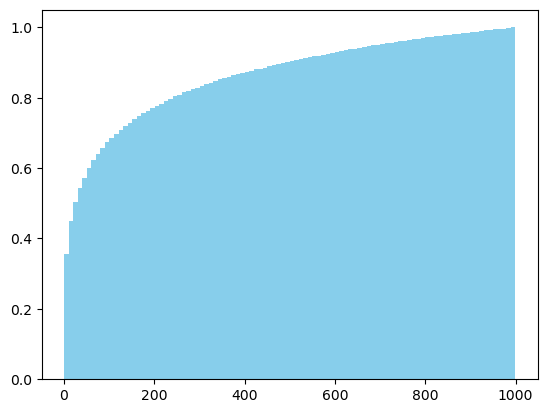

In [161]:
plt.hist(entarget_samples.numpy()/1000, cumulative=True, density=True, bins=100, log=False, color='skyblue')
plt.show()

<Figure size 800x600 with 0 Axes>

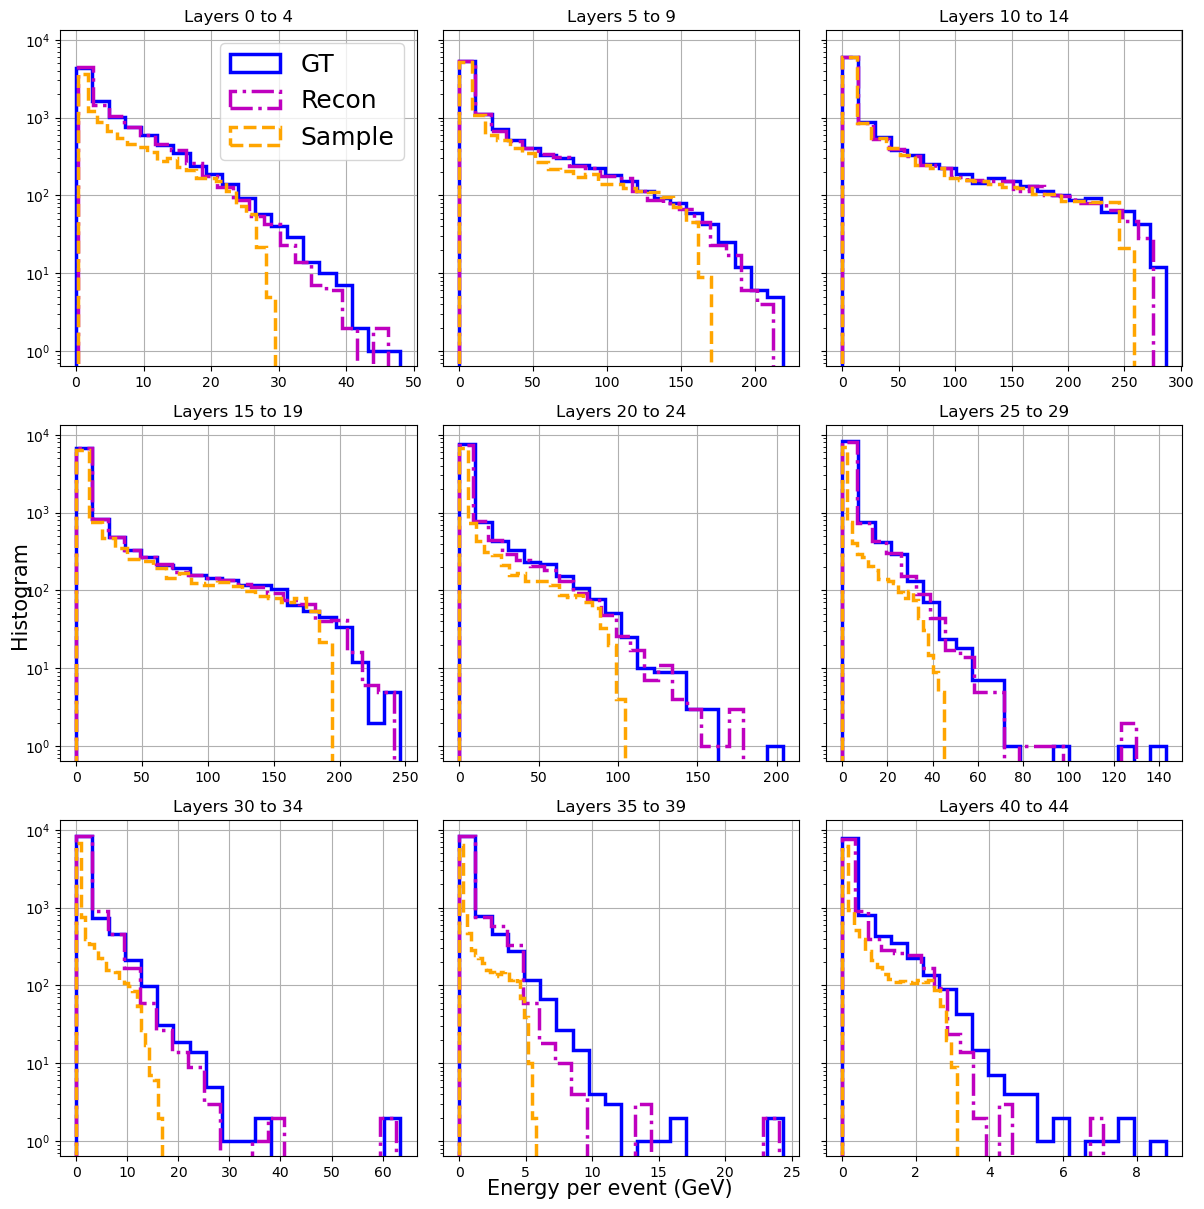

In [217]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=False, tight_layout=True)
fig.text(0.5, 0.0, 'Energy per event (GeV)', ha='center', fontsize=15)
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    ax.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000,  bins=20, log=True, histtype='step', linewidth=2.5, color="b")
    ax.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    # ax.hist(xrecon_samples_2[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
    # ax.hist(xgen_samples_qpu[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
    if i == 0:
        # ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], title=f'{ds[part]}')
        ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=18)
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


In [105]:
# entarget_samples.max()
# ll = len([1,2,5,10,20,50,100,200,500,1000,2000,5000])
# gen_bs = true_energy.shape[0]

In [86]:
xgen_samples2 = []
en_input = [1,2,3,5,10,20,30,50,100,200,300,500,1000,2000,3000,5000,10000,20000]
ll = len(en_input)
gen_bs = 2048 #true_energy.shape[0]
with torch.no_grad():
    for i in en_input:
        if reducedata:
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
        elif scaled:
            engine._model.sampler._batch_size = gen_bs # true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=1000*i, measure_time=True)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
        else:
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = sample_data.detach().cpu()*1000

        xgen_samples2.append( sample_data.detach().cpu())

xgen_samples2 = torch.cat(xgen_samples2, dim=0)

In [87]:
energy_gen = xgen_samples2.sum(dim=1)
m_energy_gen = [energy_gen[i*gen_bs:gen_bs*(i+1)].sum().item()/1000 for i in range(ll)]
sd_energy_gen = [energy_gen[i*gen_bs:gen_bs*(i+1)].std().item()/1000 for i in range(ll)]
lin_inter = np.power(m_energy_gen,1/2) * (1 - np.array(m_energy_gen)/np.array(m_energy_gen).max()) \
    + np.power(m_energy_gen,1) * np.array(m_energy_gen)/np.array(m_energy_gen).max()


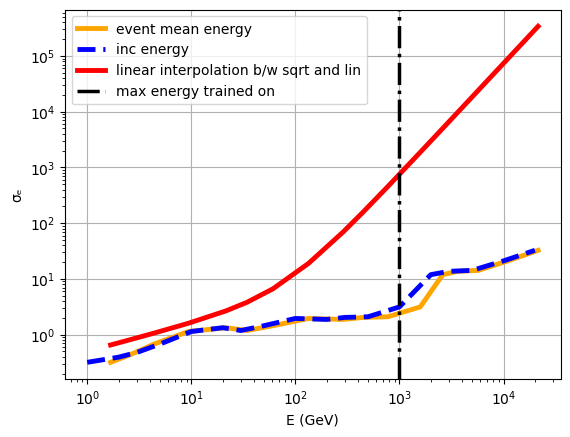

In [88]:
plt.plot(np.array(m_energy_gen)/1000, sd_energy_gen, c='orange', lw=3.5, label='event mean energy')
plt.plot((np.array(en_input)), sd_energy_gen, c='blue', lw=3.5, label='inc energy', linestyle="dashed")
plt.grid("True")
# plt.plot([1,10], np.sqrt([1,10])*np.power(10, -0.8))
plt.plot(np.array(m_energy_gen)/1000, lin_inter*np.power(10, -1.8), c='red', lw=3.5, label='linear interpolation b/w sqrt and lin')
plt.yscale('log')
plt.xscale('log')
plt.axvline(x=1000, c='black', lw=2.5, label='max energy trained on', linestyle="dashdot")
plt.legend()
plt.xlabel("E (GeV)")
plt.ylabel("σₑ")
plt.show()

In [190]:
# plt.plot(np.array(m_energy_gen), np.array(sd_energy_gen)/np.array(m_energy_gen))
# # plt.plot((np.array(en_input)*1000), sd_energy_gen)
# # plt.plot(np.array(m_energy_gen), np.sqrt(m_energy_gen)*np.power(10, -2.2))
# # plt.plot(np.array(m_energy_gen), np.sqrt(m_energy_gen)*np.power(10, 0.2))
# plt.yscale('log')
# plt.xscale('log')
# plt.axvline(x=1000000)
# plt.show()

# np.power(m_energy_gen,1/2) * (1 - np.array(m_energy_gen)/np.array(m_energy_gen).max()) + np.power(m_energy_gen,1) * np.array(m_energy_gen)/np.array(m_energy_gen).max()

In [ ]:
###########Create Synth data

In [26]:
engen_samples2 = []
xgen_samples2 = []
with torch.no_grad():
    for i,xx in enumerate(train_loader):
        if reducedata:
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
        elif scaled:
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
        else:
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = sample_data.detach().cpu()*1000

        xgen_samples2.append( sample_data.detach().cpu())
        engen_samples2.append(true_energy.detach().cpu())
        
        # if i > 30:
        #     break

xgen_samples2 = torch.cat(xgen_samples2, dim=0)
engen_samples2 = torch.cat(engen_samples2, dim=0)

In [27]:
# import torch
import h5py

# Convert tensors to numpy arrays as h5py does not support PyTorch tensors directly
tensor1_np = xgen_samples2[:100000,:].numpy()
tensor2_np = engen_samples2[:100000,:].numpy()

# Create a new HDF5 file
with h5py.File(f'/raid/javier/Datasets/CaloVAE/data/synData/dataset2_synthetic_{modelname}.hdf5', 'w') as f:
    # Create datasets for your tensors
    f.create_dataset('showers', data=tensor1_np)
    f.create_dataset('incidence energy', data=tensor2_np)

In [151]:
np.unique(HLF_1_pions.bin_edges)

array([  0,   8, 108, 208, 213, 363, 523, 533])

In [14]:
xx = next(iter(val_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

In [15]:
if reducedata:
    in_data = engine._reduce(in_data, true_energy, R=R)
fwd_output = engine.model((in_data, true_energy), False)
if reducedata:
    in_data = engine._reduceinv(in_data, true_energy, R=R)
    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
elif scaled:
    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
    engine._model.sampler._batch_size = true_energy.shape[0]
    # try:
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    # except:
        # pass
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
else:
    in_data = in_data.detach().cpu()*1000
    recon_data = fwd_output.output_activations.detach().cpu()*1000
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
    sample_data = sample_data.detach().cpu()*1000

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 4 has a total capacty of 79.15 GiB of which 8.88 MiB is free. Process 4089921 has 55.66 GiB memory in use. Including non-PyTorch memory, this process has 23.48 GiB memory in use. Of the allocated memory 22.94 GiB is allocated by PyTorch, and 38.97 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [303]:
THRSH=7
recon_data = recon_data * (recon_data > THRSH)
sample_data = sample_data * (sample_data > THRSH)

In [125]:
# HLF_1_pions.relevantLayers = [1,2,3,4,5,6,7]
# np.unique(HLF_1_pions.bin_edges)
# true_energy/1000
# HLF_1_electron.relevantLayers
true_energy[idx]/1000

tensor([696.5617], device='cuda:4')

In [218]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,44] #[i for i in range(0,5)] #[0,5,10,15,20,25,30,35,40,47,]

In [32]:
# (((in_data[:,0:108] - recon_data[:,0:108])/(in_data[:,0:108]))**2).sum(dim=1).argsort()[:20]
# (((in_data - recon_data)/(in_data+1e-5))**2).sum(dim=1).argsort()[-200:-1]
# (((in_data - recon_data))**2).sum(dim=1).argsort()[:20]

tensor([782, 151, 395, 162, 299, 660, 335, 110, 183, 313, 723, 189, 298, 119,
         57, 684, 171, 767, 537, 769, 405, 271, 709, 380, 410, 404, 653, 109,
        214,  36, 149, 289, 129, 168, 101, 549, 334, 437, 292, 757, 159, 447,
        391,  94,  81, 184, 629, 136, 204, 590, 632,   4, 282, 551, 247, 642,
        414, 158, 566, 284, 729, 368, 143, 640, 496, 489, 435,  75, 658, 702,
        373, 117,   6, 630, 114, 295, 181, 553, 186, 486, 633, 120, 643, 393,
        196, 316, 425,  27,  37, 649, 497,  96, 325, 375,  93, 154, 164, 192,
         47, 423, 205, 418, 349, 515, 473, 300, 178, 215,  16, 255, 524, 366,
        661, 714, 721, 412, 311, 319, 396, 663,  39, 264, 558, 554, 145, 501,
        399, 536, 141,   2, 736, 523, 116, 253, 442, 417, 198, 732, 420, 297,
        625, 753, 493,  31, 595, 281, 727, 461, 579, 754, 254, 616, 195, 540,
        361, 708,  21, 760,  92,  83, 427, 720, 507, 469, 563, 288, 487,  88,
        517, 431,  59,  14, 635, 452, 752, 265, 738, 619, 562, 3

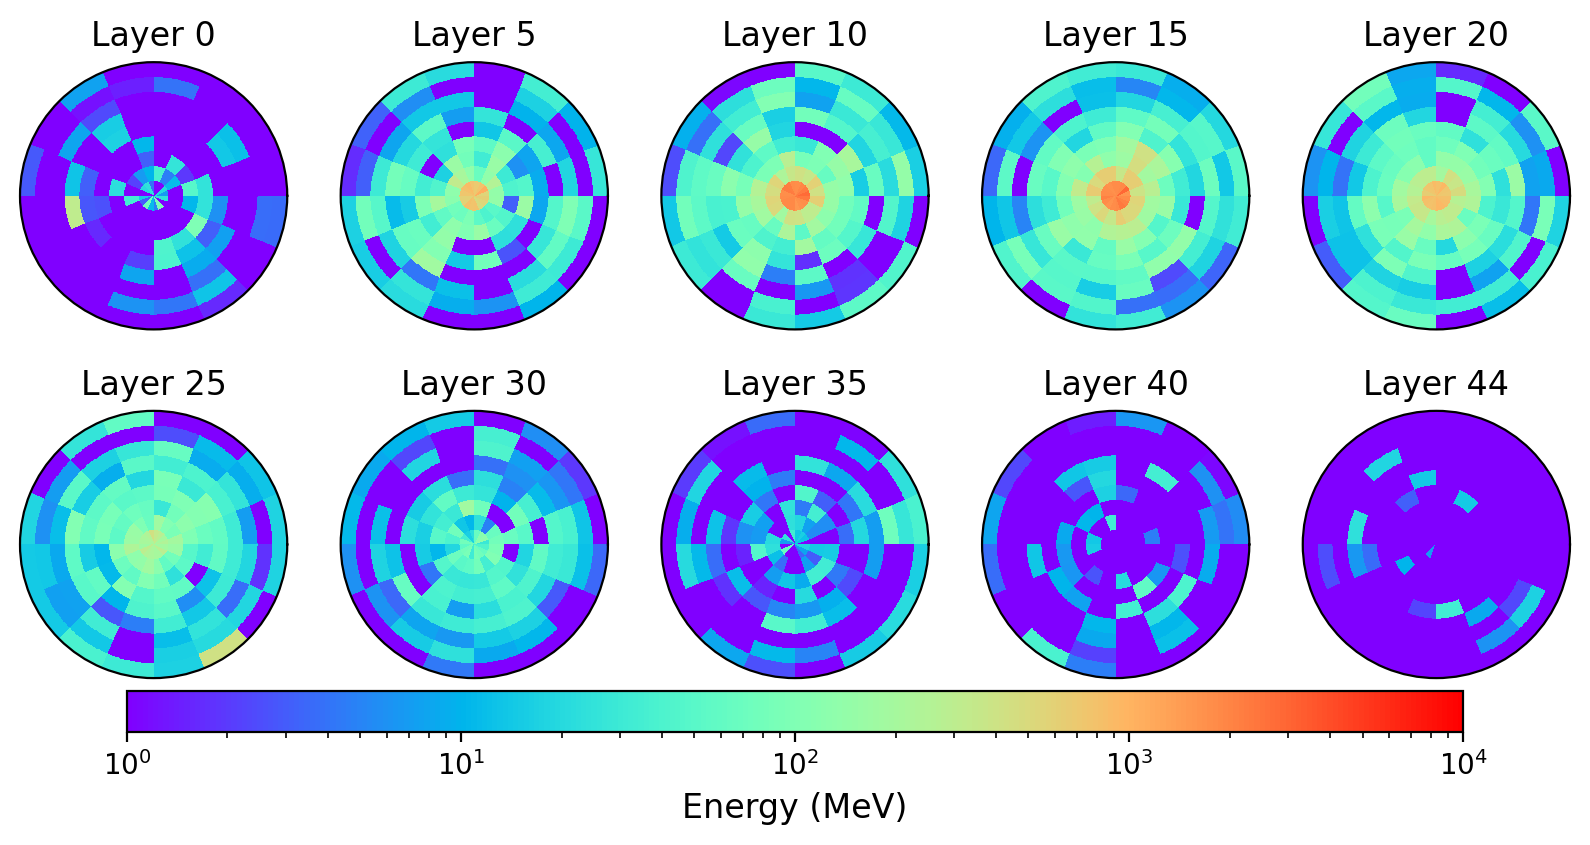

In [219]:
idx=21
# HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/target_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')

HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/target_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png', vmax=1e+3, vmin=1e+0, cmap='rainbow')
HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), vmax=1e+4, vmin=1e+0, cmap='rainbow', filename=None ) 

# HLF_1_electron.DrawAverageShower(in_data[1:1000,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/target_a_{idx}_{modelname}_{arch}_{datascaled}_{part}_avg.png')
# HLF_1_electron.DrawAverageShower(in_data[1:1000,:].detach().cpu().numpy(), filename=None)


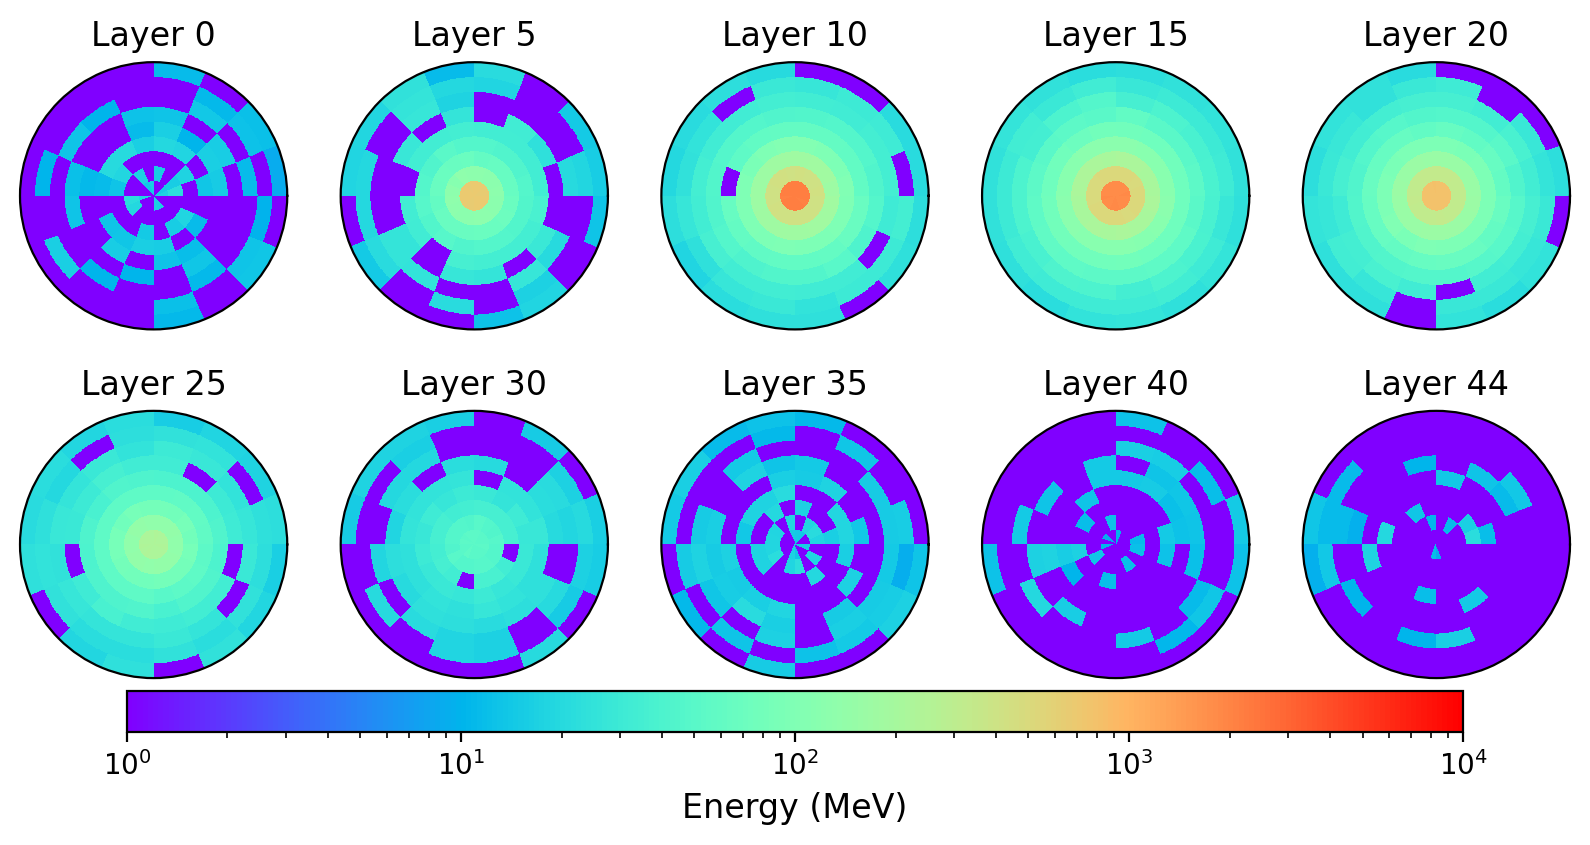

In [220]:
# HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/recon_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')

HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/recon_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png', vmax=1e+3, vmin=1e+0, cmap='rainbow')
HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=None, vmax=1e+4, vmin=1e+0, cmap='rainbow')

# HLF_1_electron.DrawAverageShower(recon_data[1:1000,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/recon_{idx}_{modelname}_{arch}_{datascaled}_{part}_avg.png')
# HLF_1_electron.DrawAverageShower(recon_data[1:1000,:].detach().cpu().numpy(), filename=None)

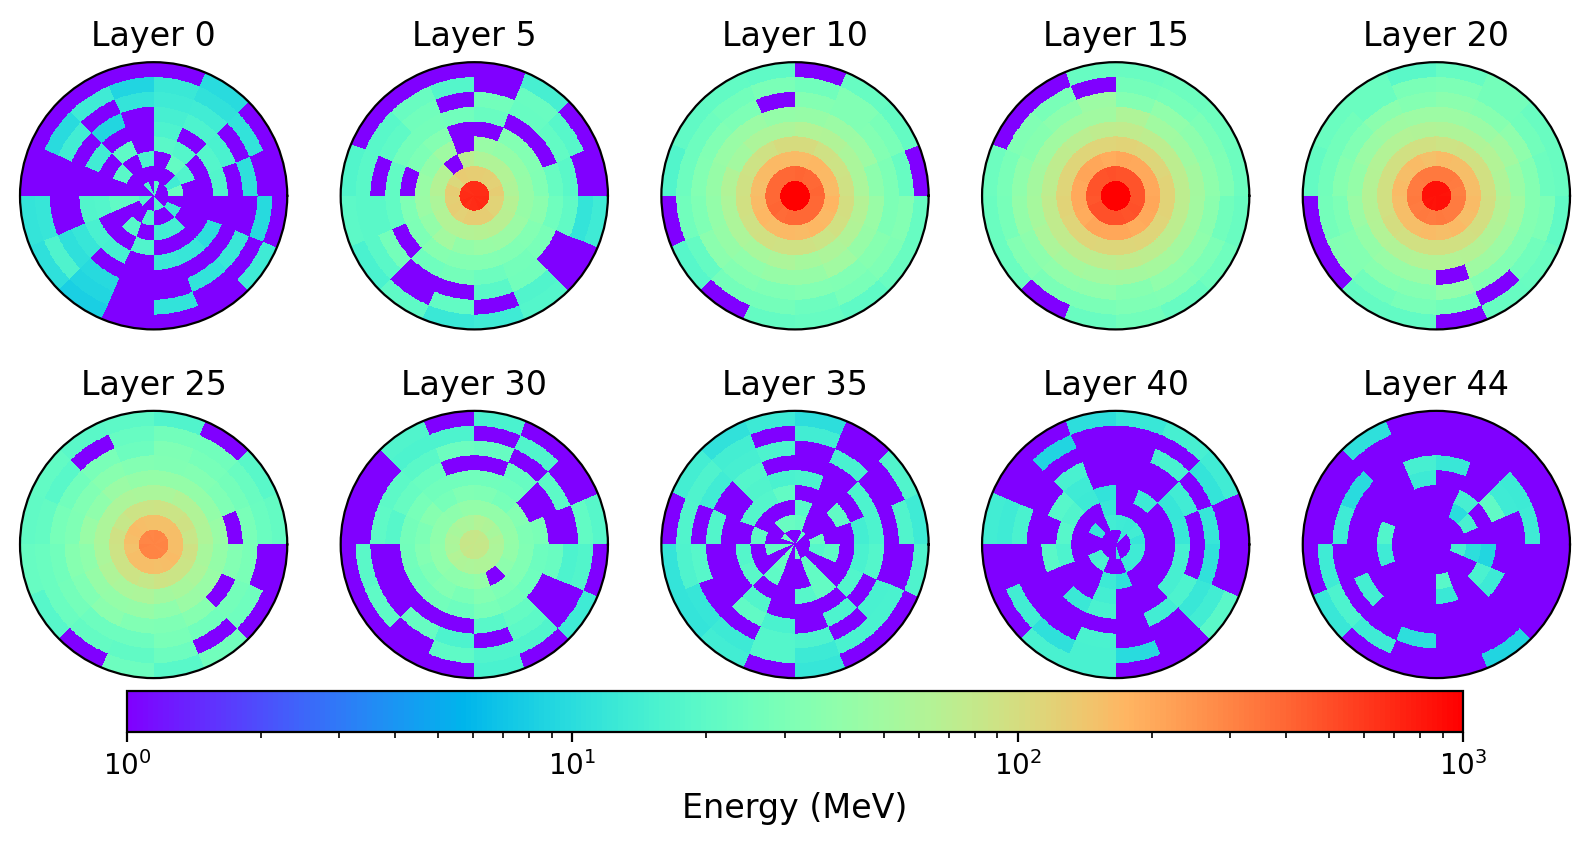

In [221]:
# HLF_1_pions.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(sample_data[1,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')

HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png', vmax=1e+3, vmin=1e+0, cmap='rainbow')
HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=None, vmax=1e+3, vmin=1e+0, cmap='rainbow')

# HLF_1_electron.DrawAverageShower(sample_data[1:1000,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_a_{idx}_{modelname}_{arch}_{datascaled}_{part}_avg.png')
# HLF_1_electron.DrawAverageShower(sample_data[1:1000,:].detach().cpu().numpy(), filename=None)

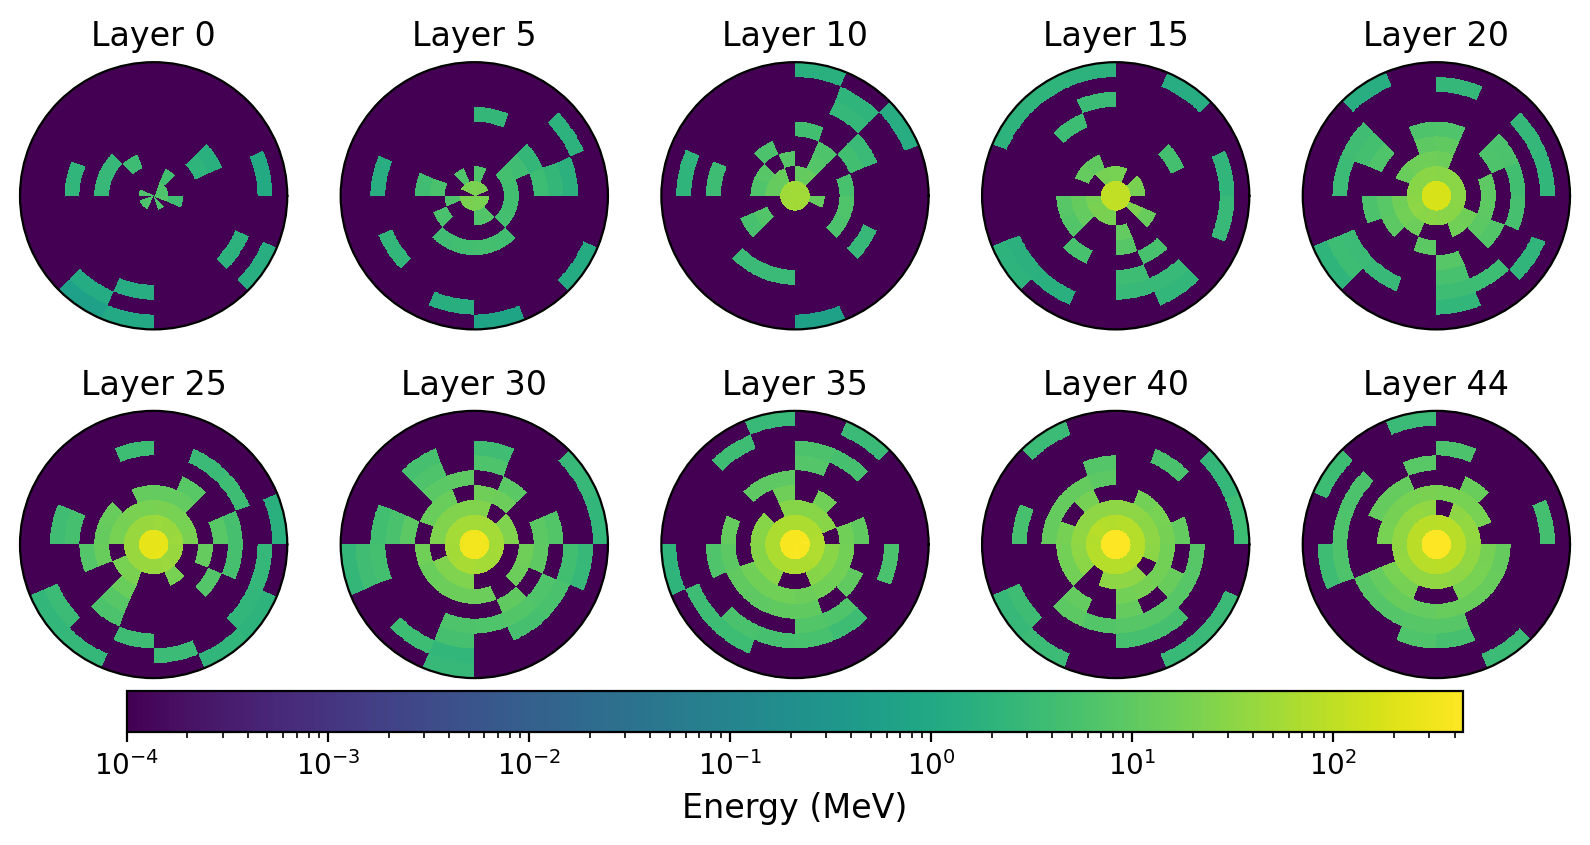

In [68]:
HLF_1_electron.DrawSingleShower(sample_data_qpu[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_QPU_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(sample_data_qpu[idx,:].detach().cpu().numpy(), filename=None)

In [195]:
#Average Shower
# modelname
idx_list = torch.tensor(range(6480))

pos_z = idx_list // 144
# pos_z
pos_theta = (idx_list - 144*pos_z) // 9
pos_theta
pos_r = (idx_list - 144*pos_z) % 9
pos_r

tensor([0, 1, 2,  ..., 6, 7, 8])

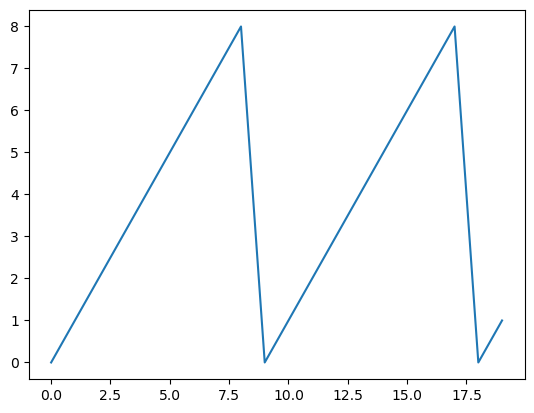

In [88]:
plt.plot(pos_r[:20].detach().numpy())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Let's define the positional_encoding function as before
def positional_encoding(pos, d_model):
    """
    Computes the positional encoding for a given position and model dimension.
    Arguments:
    pos -- a scalar or a vector of positions
    d_model -- the dimensionality of the model
    Returns:
    pe -- the positional encoding for the given position(s)
    """
    pe = np.zeros((len(pos), d_model))
    for i in range(d_model):
        div_term = np.exp(i * -np.log(10000.0) / d_model)
        if i % 2 == 0:
            pe[:, i] = np.sin(pos * div_term)
        else:
            pe[:, i] = np.cos(pos * div_term)
    return pe

# Define the sentence and parameters
sentence = "the dog wags the tail more often during the night"
words = sentence.split()
num_words = len(words)
d_model = 512  # The dimensionality is often larger, such as 512

# Calculate the positional encoding for the number of words
positions = np.arange(num_words)
pe = positional_encoding(positions, d_model)

# For visualization, let's plot just the first two dimensions
plt.figure(figsize=(14, 8))
plt.plot(positions, pe[:, 0], 'o-', label='Dimension 1 (sin)')
plt.plot(positions, pe[:, 1], 'o-', label='Dimension 2 (cos)')
plt.xticks(positions, words, rotation=90)
plt.xlabel('Position')
plt.ylabel('Positional Encoding Value')
plt.title('Positional Encoding of Sentence')
plt.legend()
plt.grid(True)
plt.show()


In [80]:
def positional_encoding(pos, d_model):
    """
    Computes the positional encoding for a given position and model dimension.
    Arguments:
    pos -- a scalar or a vector of positions
    d_model -- the dimensionality of the model
    Returns:
    pe -- the positional encoding for the given position(s)
    """
    pe = torch.zeros((len(pos), d_model))
    for i in range(d_model):
        div_term = torch.exp(i * -torch.log(torch.tensor([10000.0])) / d_model)
        if i % 2 == 0:
            pe[:, i] = torch.sin(pos * div_term)
        else:
            pe[:, i] = torch.cos(pos * div_term)
    return pe.detach().sum(dim=1)

In [104]:
def _cylinder_pos_enc(lz=512,ltheta=512, lr=512):
    PE_z = positional_encoding(torch.tensor(range(45)),lz).repeat_interleave(144)
    PE_theta = positional_encoding(torch.tensor(range(16)),ltheta).repeat_interleave(9).repeat(45)
    PE_r = positional_encoding(torch.tensor(range(9)),lr).repeat(16*45)
    
    return PE_z + PE_theta + PE_r, PE_z, PE_theta , PE_r

In [94]:
PE_z = positional_encoding(torch.tensor(range(16)),128)
PE_z

tensor([64.0000, 69.3392, 69.7215, 66.0675, 61.1625, 57.7595, 56.8805, 57.5240,
        57.8537, 56.7987, 54.7786, 53.0912, 52.6394, 53.1565, 53.5532, 52.9760])

In [95]:
# plt.plot(PE_z.numpy())
# plt.plot(PE[:,1].detach().numpy())
# PE_z.repeat_interleave(45)
if 1 == True:
    print(1)

1


In [96]:
# positional_encoding(torch.tensor(range(16)),128).repeat_interleave(9).repeat(45)[:145]
# positional_encoding(torch.tensor(range(45)),128).repeat_interleave(144)
# positional_encoding(torch.tensor(range(9)),128).repeat(16*45)

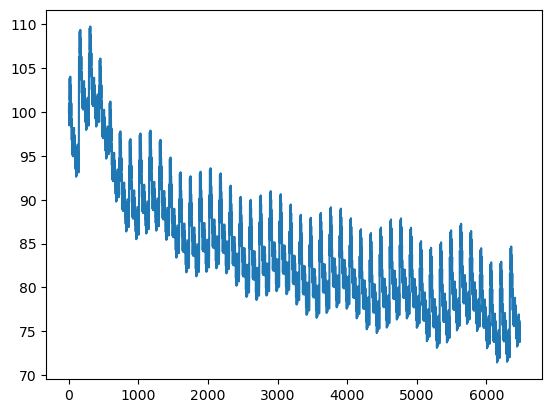

In [112]:
cyl_enc, PE_z, PE_theta , PE_r = _cylinder_pos_enc(lz=128, ltheta=64, lr=9)
plt.plot(cyl_enc.numpy())

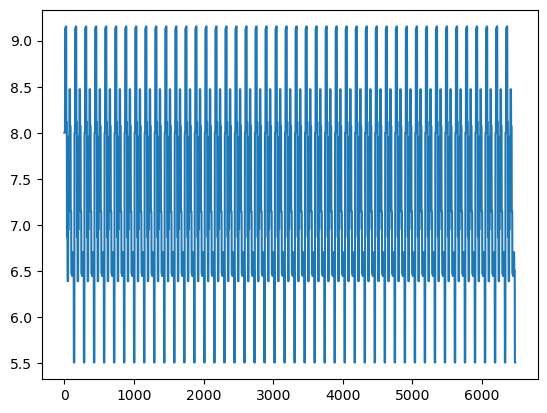

In [110]:
plt.plot(PE_theta.numpy()[:-1])

In [175]:
(in_data + cyl_enc)

tensor([[194.8870, 194.8976, 195.0907,  ..., 172.9958, 173.6140, 173.7842],
        [217.4611, 194.8976, 195.0907,  ..., 172.9958, 173.6140, 173.7842],
        [192.0000, 203.3723, 195.0907,  ..., 172.9958, 173.6140, 173.7842],
        ...,
        [192.0000, 194.8976, 195.0907,  ..., 172.9958, 173.6140, 173.7842],
        [197.3728, 202.7562, 195.0907,  ..., 172.9958, 173.6140, 173.7842],
        [192.0000, 194.8976, 195.0907,  ..., 172.9958, 173.6140, 173.7842]])

In [119]:

# cyl_enc.to(in_data.device)
in_data.to('cuda')

tensor([[ 0.0000,  6.9262,  1.3491,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 2.5212,  4.6352,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 2.6255, 33.7257, 21.9538,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  2.8941,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.4203,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

In [172]:
run = wandb.Api(api_key= "").run("jtoledo/caloqvae/n9y23yq6")
summary = run.summary
hist = run.history()
hist.head(20)
true_indices = [i for i, x in enumerate(np.isnan(hist["val_kl_loss"])) if x==False]

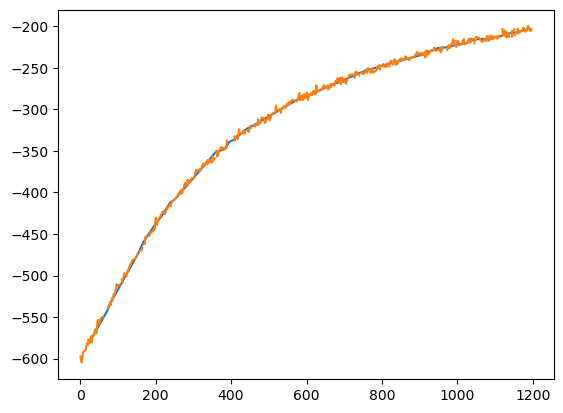

In [185]:
plt.plot(hist["_step"][true_indices], hist["val_kl_loss"][true_indices])
plt.plot(hist["_step"], hist["kl_loss"])

In [187]:
prelu_dict = {}
for i in range(4):
    for name, param in engine.model.encoder._networks[i][0].seq2[4].named_parameters():
        # print(name, param.data.detach().cpu().numpy())
        prelu_dict[i] = param.data.detach().cpu().numpy()

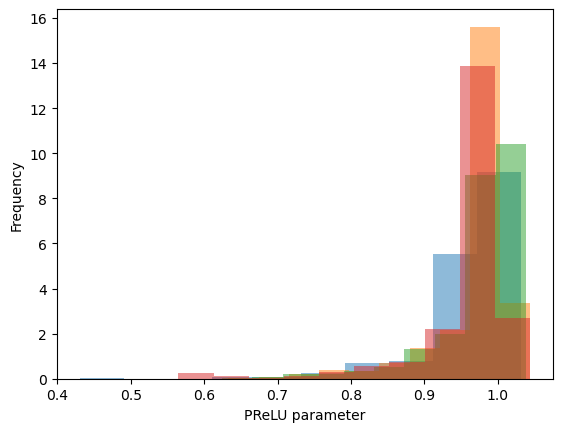

In [188]:
for i in range(4):
    plt.hist(prelu_dict[i], alpha=0.5, density=True)
plt.xlabel("PReLU parameter")
plt.ylabel("Frequency")
plt.show()

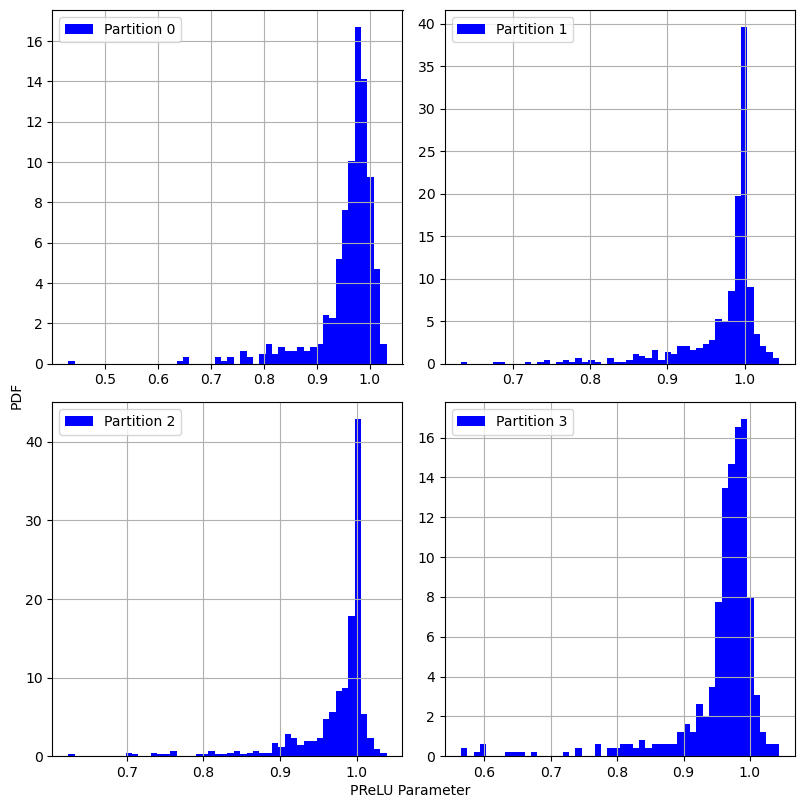

In [189]:
fig, axes = plt.subplots(2,2, figsize=(8,8), tight_layout=True)
fig.text(0.5, 0.0, 'PReLU Parameter', ha='center')
# fig.text(0.5, 1.0, f'PDF', ha='center', fontsize=12)
fig.text(0.0, 0.5, 'PDF', va='center', rotation='vertical')

axes[0,0].hist(prelu_dict[0], bins=50, density=True, color="b")
axes[0,0].legend(["Partition 0"])
axes[0,0].grid("True")

axes[0,1].hist(prelu_dict[1], bins=50, color="b", density=True)
axes[0,1].legend(["Partition 1"])
axes[0,1].grid("True")

axes[1,0].hist(prelu_dict[2], bins=50, color="b", density=True)
axes[1,0].legend(["Partition 2"])
axes[1,0].grid("True")

axes[1,1].hist(prelu_dict[3], bins=50, color="b", density=True)
axes[1,1].legend(["Partition 3"])
axes[1,1].grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/PReLU_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [176]:
####
import numpy as np

In [177]:
def _gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=128, temp_opt_samp_size = 128):
    τₛ = 0.020+0.136+0.021
    τₚ = 15.92


    # temp_steps=5
    # training_size = 80000
    # val_size = 10000
    # val_bs = 1024
    # train_bs = 256
    # temp_opt_samp_size = 256

    train_b_num = np.ceil(training_size/train_bs) # assuming batchsize 128
    val_b_num = np.ceil(val_size/val_bs) # assuming batchsize 1024
    train_time_per_epoch = (training_size*τₛ + train_b_num*τₚ)
    val_time_per_epoch = (val_size*τₛ + val_b_num*τₚ)
    temp_opt_time = (temp_opt_samp_size*τₛ+τₚ)*temp_steps

    # print(train_time_per_epoch/1000) #seconds
    # print(val_time_per_epoch/1000) #seconds
    # print(temp_opt_time/1000) #seconds

    # Milestone 1
    # print( (val_time_per_epoch + temp_opt_time*val_b_num)/1000)

    # Milestone 2
    # print( (train_time_per_epoch + temp_opt_time*train_b_num)/1000)

    # Milestone 3
    # print( 100*(train_time_per_epoch + temp_opt_time*train_b_num)/1000/60)

    # Milestone 4
    full_epoch_cycle = train_time_per_epoch + val_time_per_epoch + temp_opt_time*(train_b_num+val_b_num)
    # print(100*full_epoch_cycle/1000/60) #minutes
    return (val_time_per_epoch + temp_opt_time*val_b_num)/1000, (train_time_per_epoch + temp_opt_time*train_b_num)/1000/60, \
        100*(train_time_per_epoch + temp_opt_time*train_b_num)/1000/60/60, 100*full_epoch_cycle/1000/60/60, \
        (val_time_per_epoch + temp_opt_time*1)/1000


In [38]:
_qpu_time_to_train = [_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[0] for i in [128,256,512,1024]]

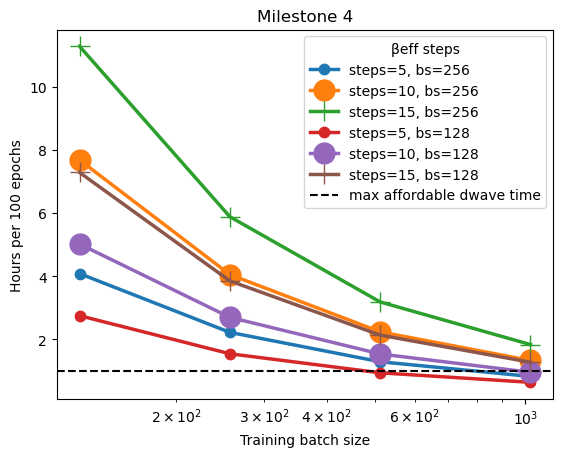

In [68]:
# plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[3] for i in [128,256,512,1024]],  marker='.', markersize=15, linewidth=2.5)
# plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[3] for i in [128,256,512,1024]],  marker='o', markersize=15, linewidth=2.5)
# plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[3] for i in [128,256,512,1024]],  marker='+', markersize=15, linewidth=2.5)
# plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[3] for i in [128,256,512,1024]],  marker='.', markersize=15, linewidth=2.5)
# plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[3] for i in [128,256,512,1024]],  marker='o', markersize=15, linewidth=2.5)
# plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[3] for i in [128,256,512,1024]],  marker='+', markersize=15, linewidth=2.5)

plt.plot([128,256,512,1024], np.array([_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[3] for i in [128,256,512,1024]])/1.5,  marker='.', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], np.array([_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[3] for i in [128,256,512,1024]])/1.5,  marker='o', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], np.array([_gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[3] for i in [128,256,512,1024]])/1.5,  marker='+', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], np.array([_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[3] for i in [128,256,512,1024]])/1.5,  marker='.', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], np.array([_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[3] for i in [128,256,512,1024]])/1.5,  marker='o', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], np.array([_gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[3] for i in [128,256,512,1024]])/1.5,  marker='+', markersize=15, linewidth=2.5)
plt.xscale("log")
plt.axhline(y=1.0, color='black', linestyle='--')

plt.title("Milestone 4")
plt.xlabel("Training batch size")
plt.ylabel("Hours per 100 epochs")
plt.legend(["steps=5, bs=256","steps=10, bs=256","steps=15, bs=256", "steps=5, bs=128","steps=10, bs=128","steps=15, bs=128", "max affordable dwave time"], title="βeff steps")
plt.show()

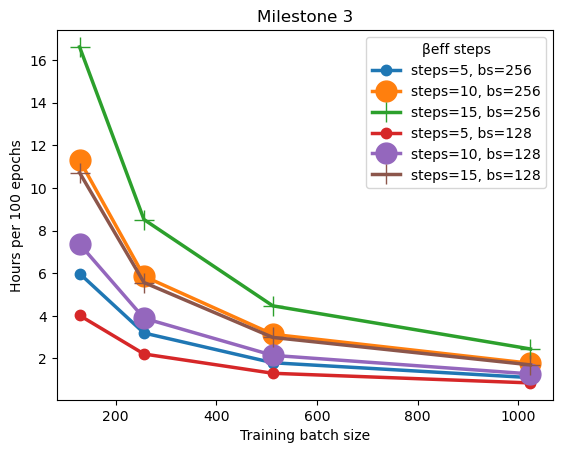

In [30]:
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[2] for i in [128,256,512,1024]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[2] for i in [128,256,512,1024]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[2] for i in [128,256,512,1024]],  marker='+', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[2] for i in [128,256,512,1024]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[2] for i in [128,256,512,1024]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[2] for i in [128,256,512,1024]],  marker='+', markersize=15, linewidth=2.5)

plt.title("Milestone 3")
plt.xlabel("Training batch size")
plt.ylabel("Hours per 100 epochs")
plt.legend(["steps=5, bs=256","steps=10, bs=256","steps=15, bs=256", "steps=5, bs=128","steps=10, bs=128","steps=15, bs=128"], title="βeff steps")
plt.show()

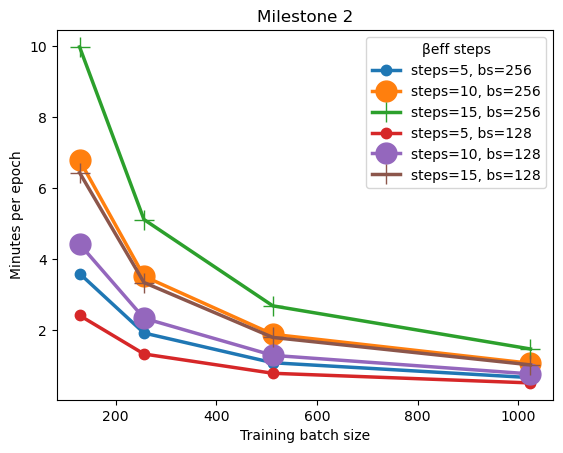

In [27]:
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[1] for i in [128,256,512,1024]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[1] for i in [128,256,512,1024]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[1] for i in [128,256,512,1024]],  marker='+', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[1] for i in [128,256,512,1024]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[1] for i in [128,256,512,1024]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[1] for i in [128,256,512,1024]],  marker='+', markersize=15, linewidth=2.5)

plt.title("Milestone 2")
plt.xlabel("Training batch size")
plt.ylabel("Minutes per epoch")
plt.legend(["steps=5, bs=256","steps=10, bs=256","steps=15, bs=256", "steps=5, bs=128","steps=10, bs=128","steps=15, bs=128"], title="βeff steps")
plt.show()

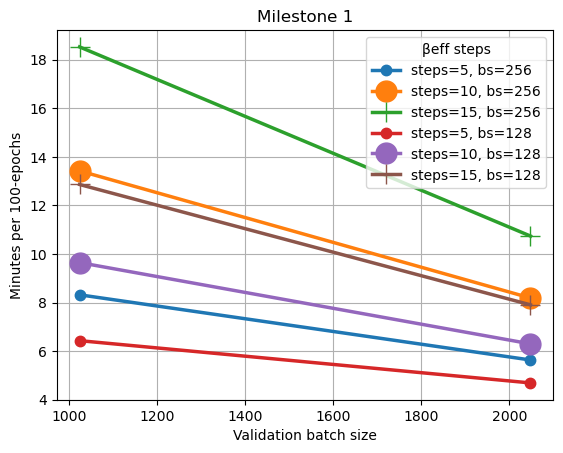

In [45]:
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 256)[0] for i in [1024,2048]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 256)[0] for i in [1024,2048]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 256)[0] for i in [1024,2048]],  marker='+', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 128)[0] for i in [1024,2048]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 128)[0] for i in [1024,2048]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 128)[0] for i in [1024,2048]],  marker='+', markersize=15, linewidth=2.5)

plt.title("Milestone 1")
plt.xlabel("Validation batch size")
plt.ylabel("Minutes per 100-epochs")
plt.legend(["steps=5, bs=256","steps=10, bs=256","steps=15, bs=256", "steps=5, bs=128","steps=10, bs=128","steps=15, bs=128"], title="βeff steps")
# plt.legend(["steps=10, bs=256","steps=15, bs=256", "steps=10, bs=128","steps=15, bs=128"], title="βeff steps")
plt.grid("True")
plt.show()

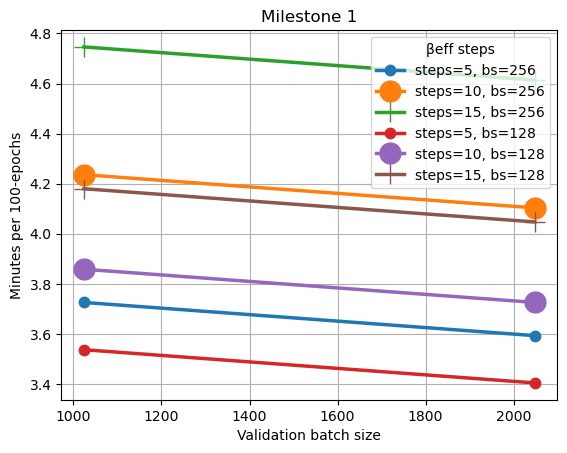

In [178]:
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 256)[4] for i in [1024,2048]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 256)[4] for i in [1024,2048]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 256)[4] for i in [1024,2048]],  marker='+', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 128)[4] for i in [1024,2048]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 128)[4] for i in [1024,2048]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 128)[4] for i in [1024,2048]],  marker='+', markersize=15, linewidth=2.5)

plt.title("Milestone 1")
plt.xlabel("Validation batch size")
plt.ylabel("Minutes per 100-epochs")
plt.legend(["steps=5, bs=256","steps=10, bs=256","steps=15, bs=256", "steps=5, bs=128","steps=10, bs=128","steps=15, bs=128"], title="βeff steps")
# plt.legend(["steps=10, bs=256","steps=15, bs=256", "steps=10, bs=128","steps=15, bs=128"], title="βeff steps")
plt.grid("True")
plt.show()

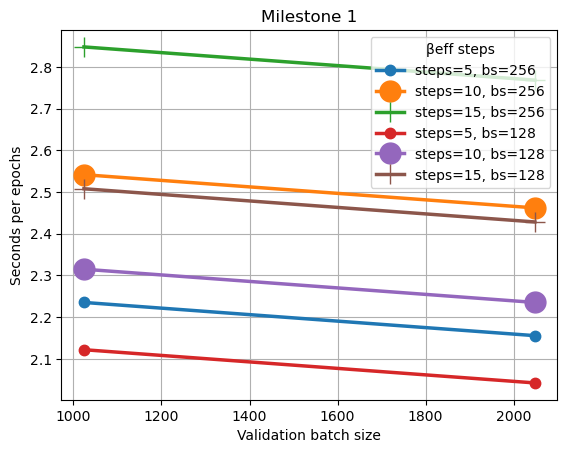

In [63]:
plt.plot([1024,2048], [_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 256)[4] for i in [1024,2048]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 256)[4] for i in [1024,2048]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [_gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 256)[4] for i in [1024,2048]],  marker='+', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 128)[4] for i in [1024,2048]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 128)[4] for i in [1024,2048]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [_gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 128)[4] for i in [1024,2048]],  marker='+', markersize=15, linewidth=2.5)

plt.title("Milestone 1")
plt.xlabel("Validation batch size")
plt.ylabel("Seconds per epochs")
plt.legend(["steps=5, bs=256","steps=10, bs=256","steps=15, bs=256", "steps=5, bs=128","steps=10, bs=128","steps=15, bs=128"], title="βeff steps")
# plt.legend(["steps=10, bs=256","steps=15, bs=256", "steps=10, bs=128","steps=15, bs=128"], title="βeff steps")
plt.grid("True")
plt.show()

In [61]:
import struct

def float32_to_binary(num):
    # Check if the number is negative
    # if num < 0:
        # raise ValueError("Number must be positive")

    # Convert the float number to 32-bit binary format
    packed = struct.pack('f', num)
    
    # Convert the bytes to an integer
    i = int.from_bytes(packed, byteorder='little', signed=False)
    
    # Format the integer to its binary representation and pad with zeros to 32 bits
    return format(i, '032b')

# Example usage
num = 123.456
binary_representation = float32_to_binary(num)
print("Binary representation of", num, ":", binary_representation)


Binary representation of 123.456 : 01000010111101101110100101111001


In [62]:
num = -0.456
binary_representation = float32_to_binary(num)
print("Binary representation of", num, ":", binary_representation)

Binary representation of -0.456 : 10111110111010010111100011010101


In [65]:
#### QPU ratios

In [12]:
beta_KL, beta_list_KL, rbm_energy_list_KL, dwave_energies_list_KL = engine.model.find_beta(7.0, 0.01, 20)

Epoch 0: beta = 7.0
Epoch 1: beta = 3.338779296875
Epoch 2: beta = 3.3358007812499997
Epoch 3: beta = 3.3378271484374995
Epoch 4: beta = 3.3469091796874997
Epoch 5: beta = 3.3910302734374995
Epoch 6: beta = 3.4593017578124994
Epoch 7: beta = 3.5367041015624996
Epoch 8: beta = 3.5954199218749996
Epoch 9: beta = 3.6540624999999998
Epoch 10: beta = 3.703076171875
Epoch 11: beta = 3.551201171875
Epoch 12: beta = 3.4194628906249998
Epoch 13: beta = 3.3605371093749996
Epoch 14: beta = 3.3614941406249996
Epoch 15: beta = 3.3382080078125
Epoch 16: beta = 3.312255859375
Epoch 17: beta = 3.315810546875
Epoch 18: beta = 3.284833984375
Epoch 19: beta = 3.2728125
Epoch 20: beta = 3.261064453125


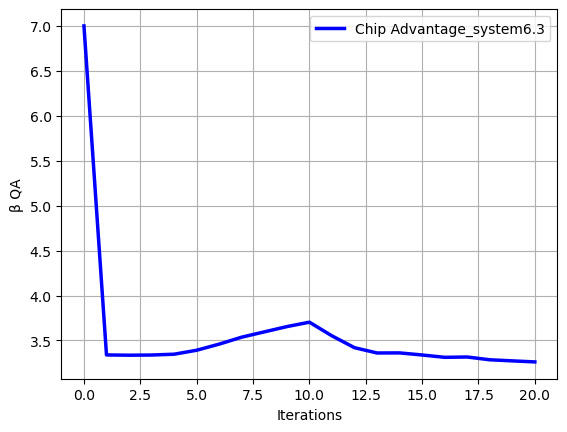

In [13]:
plt.plot(beta_list_KL, linewidth=2.5, color="b" )
plt.xlabel("Iterations")
plt.ylabel("β QA")
plt.legend([f'Chip {engine.model._qpu_sampler.properties["chip_id"]}'])
# plt.title(f'{ds[part]}')
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/beta_QA_{engine.model._qpu_sampler.properties["chip_id"]}_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [52]:
if 1:
    print(1)

1


In [21]:
beta_Hao, beta_list_Hao, rbm_energy_list_Hao, dwave_energies_list_Hao = engine.model.find_beta(4.0, 0.01, 20, 10.0, 'Hao')

Epoch 0: beta = 4.0
Epoch 1: beta = 3.996094036912361
Epoch 2: beta = 3.995979709216824
Epoch 3: beta = 3.9995013899902165
Epoch 4: beta = 3.9882636701379037
Epoch 5: beta = 3.8830663522885716
Epoch 6: beta = 3.768268861946719
Epoch 7: beta = 3.697319921345327
Epoch 8: beta = 3.602278066669326
Epoch 9: beta = 3.5579129153635676
Epoch 10: beta = 3.5046034784898494
Epoch 11: beta = 3.4622490621321105
Epoch 12: beta = 3.4557395974940945
Epoch 13: beta = 3.4517580462610673
Epoch 14: beta = 3.356733257512331
Epoch 15: beta = 3.1898415424380966
Epoch 16: beta = 3.156786802700584
Epoch 17: beta = 3.1417194908564556
Epoch 18: beta = 3.160650288701051
Epoch 19: beta = 3.1699955123429597
Epoch 20: beta = 3.1820254436452124


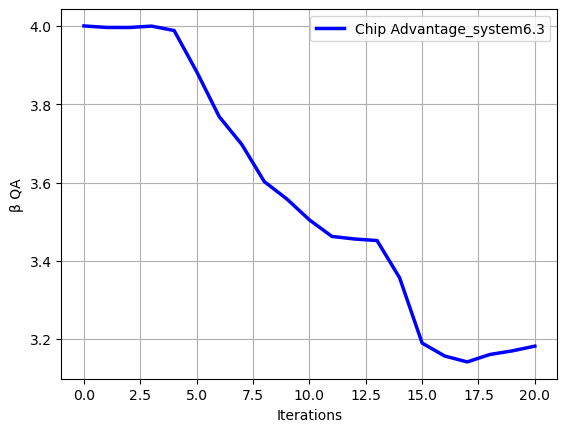

In [22]:
plt.plot(beta_list_Hao, linewidth=2.5, color="b" )
plt.xlabel("Iterations")
plt.ylabel("β QA")
plt.legend([f'Chip {engine.model._qpu_sampler.properties["chip_id"]}'])
# plt.title(f'{ds[part]}')
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/beta_QA_{engine.model._qpu_sampler.properties["chip_id"]}_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
plt.plot(beta_list_Hao, linewidth=2.5, color="b" )

In [51]:
beta_init = 1.8
# lr = 0.01
num_epochs = 20
Δbeta = 0.2
beta = beta_init
beta_list = []
rbm_energy_list = []
dwave_energies_list = []
mean_rbm_energy_list = []
mean_dwave_energy_list = []
var_rbm_energy_list = []
var_dwave_energy_list = []
training_results = {}

for epoch in range(num_epochs+1):
    _,_,_,_, dwave_weights_rbm, dwave_bias_rbm = engine.model.ising_model(1.0)
    # _,_,_,_, dwave_weights_rbm, dwave_bias_rbm = engine.model.ising_model(1.0)
    h, J, qubit_idxs, idx_dict, dwave_weights, dwave_bias = engine.model.ising_model(1.0 / beta)
    if epoch == 0:
        # prbm_sampler = PGBS(self.prior, 512, 3000)
        p0_state, p1_state, p2_state, p3_state = engine.model.sampler.block_gibbs_sampling()
        p0_ising = p0_state * 2 - 1
        p1_ising = p1_state * 2 - 1
        p2_ising = p2_state * 2 - 1
        p3_ising = p3_state * 2 - 1
        rbm_energies = engine.model.ising_energy(p0_ising, p1_ising, p2_ising, p3_ising, dwave_weights_rbm, dwave_bias_rbm)
        rbm_energies = rbm_energies.detach().cpu().numpy()

    response = engine.model._qpu_sampler.sample_ising(h, J, num_reads=256, auto_scale=False)
    dwave_samples, dwave_energies, origSamples = engine.model.batch_dwave_samples(response, qubit_idxs)
    # dwave_samples, dwave_energies = self.batch_dwave_samples(response, qubit_idxs)
    nonpl = len(idx_dict['0'])
    dwave_1, dwave_2, dwave_3, dwave_4 = dwave_samples[:,0:nonpl], dwave_samples[:,nonpl:2*nonpl], dwave_samples[:,2*nonpl:3*nonpl], dwave_samples[:,3*nonpl:4*nonpl]
    dwave_1_t = torch.tensor(dwave_1).to(p0_ising.device).float()
    dwave_2_t = torch.tensor(dwave_2).to(p0_ising.device).float()
    dwave_3_t = torch.tensor(dwave_3).to(p0_ising.device).float()
    dwave_4_t = torch.tensor(dwave_4).to(p0_ising.device).float()
    dwave_energies = engine.model.ising_energy(dwave_1_t, dwave_2_t, dwave_3_t, dwave_4_t, dwave_weights_rbm, dwave_bias_rbm)
    dwave_energies = dwave_energies.detach().cpu().numpy()
    mean_rbm_energy = np.mean(rbm_energies)
    mean_dwave_energy = np.mean(dwave_energies)
    var_rbm_energy = np.var(rbm_energies)
    var_dwave_energy = np.var(dwave_energies)

    rbm_energy_list.append(rbm_energies)
    dwave_energies_list.append(dwave_energies)
    mean_rbm_energy_list.append(mean_rbm_energy)
    mean_dwave_energy_list.append(mean_dwave_energy)
    var_rbm_energy_list.append(var_rbm_energy)
    var_dwave_energy_list.append(var_dwave_energy)
    beta_list.append(beta)
    print (f'Epoch {epoch}: beta = {beta}, DW/RBM = {mean_dwave_energy/mean_rbm_energy}')
    beta = beta + Δbeta #lr * (mean_dwave_energy - mean_rbm_energy)

Epoch 0: beta = 1.8, DW/RBM = 1.0038493871688843
Epoch 1: beta = 2.0, DW/RBM = 1.0031877756118774
Epoch 2: beta = 2.2, DW/RBM = 1.0028849840164185
Epoch 3: beta = 2.4000000000000004, DW/RBM = 1.0024505853652954
Epoch 4: beta = 2.6000000000000005, DW/RBM = 1.0024287700653076
Epoch 5: beta = 2.8000000000000007, DW/RBM = 1.001915454864502
Epoch 6: beta = 3.000000000000001, DW/RBM = 1.0009799003601074
Epoch 7: beta = 3.200000000000001, DW/RBM = 1.000126838684082
Epoch 8: beta = 3.4000000000000012, DW/RBM = 0.9994146823883057
Epoch 9: beta = 3.6000000000000014, DW/RBM = 0.9978249669075012
Epoch 10: beta = 3.8000000000000016, DW/RBM = 0.9991049766540527
Epoch 11: beta = 4.000000000000002, DW/RBM = 0.9986292123794556
Epoch 12: beta = 4.200000000000002, DW/RBM = 0.9981077909469604
Epoch 13: beta = 4.400000000000002, DW/RBM = 0.9974026083946228
Epoch 14: beta = 4.600000000000002, DW/RBM = 0.9959891438484192
Epoch 15: beta = 4.8000000000000025, DW/RBM = 0.9953572154045105
Epoch 16: beta = 5.0000

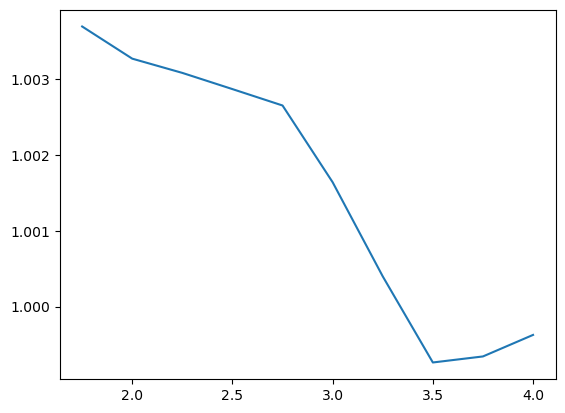

In [35]:
# plt.plot( rbmrbm_energy_list
plt.plot( beta_list , np.array(mean_dwave_energy_list) / np.array(mean_rbm_energy_list))

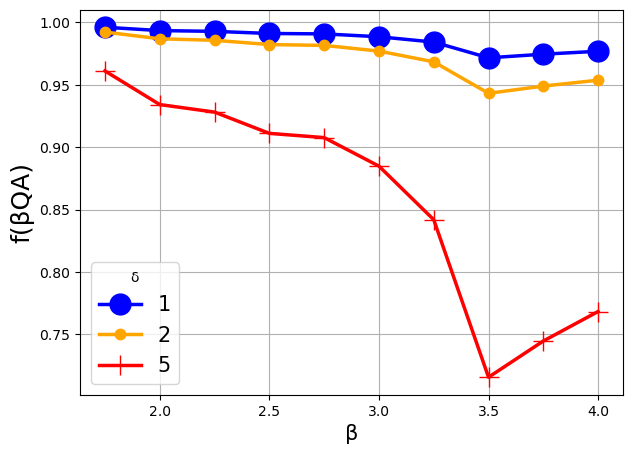

In [37]:
plt.figure(figsize=(7,5), dpi=100)

plt.plot(beta_list, 1 + np.array([np.var(dwave_energies_list[i]) for i in range(len(dwave_energies_list))])/mean_rbm_energy_list, marker='o', markersize=15, linewidth=2.5, c='blue' )
plt.plot(beta_list, 1 + 2 * np.array([np.var(dwave_energies_list[i]) for i in range(len(dwave_energies_list))])/mean_dwave_energy_list, marker='.', markersize=15, linewidth=2.5, c='orange' )
plt.plot(beta_list, 1 + 10 * np.array([np.var(dwave_energies_list[i]) for i in range(len(dwave_energies_list))])/mean_dwave_energy_list, marker='+', markersize=15, linewidth=2.5, c='red')
plt.legend(["1","2","5"], title="δ", fontsize=15)
plt.xlabel("β", fontsize=15)
# plt.axvspan(9, 9.5, color='purple', alpha=0.3)
# label_x = (18.5) / 2
# label_y = 0.2  # For example, 80% of the way up the y-axis
# plt.text(label_x, label_y, 'Fixed point', horizontalalignment='center', verticalalignment='center', rotation=90, fontsize=15)

# plt.ylabel("δ σ**2/<H>")
plt.ylabel("f(βQA)", fontsize=18)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/stability_analysis_meth2.png')
plt.show()

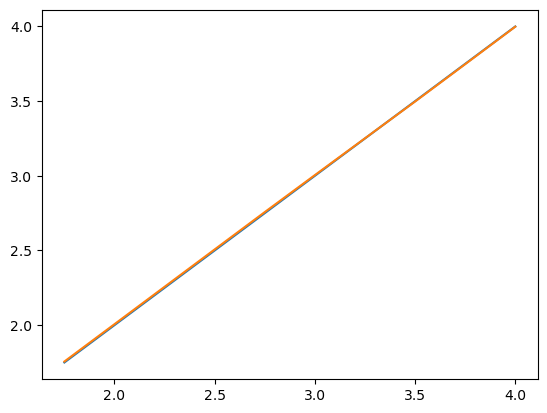

In [38]:
plt.plot(beta_list, beta_list)
plt.plot(beta_list, beta_list * np.array(mean_dwave_energy_list)/np.array(mean_rbm_energy_list))

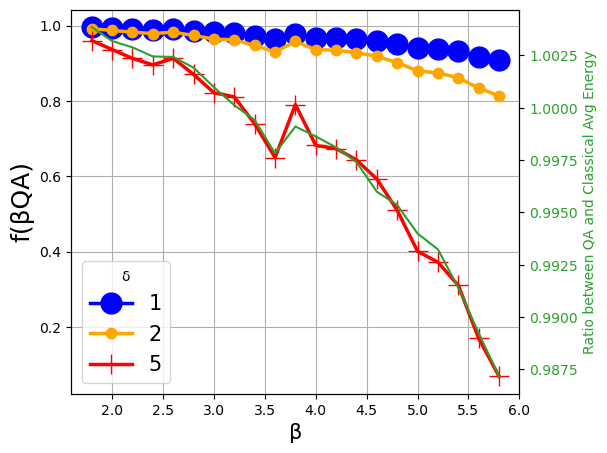

In [78]:

fig, ax1 = plt.subplots() 
# fig.figure(figsize=(7,5), dpi=100)
ax1.plot(beta_list, 1 + np.array([np.var(dwave_energies_list[i]) for i in range(len(dwave_energies_list))])/mean_rbm_energy_list, marker='o', markersize=15, linewidth=2.5, c='blue' )
ax1.plot(beta_list, 1 + 2 * np.array([np.var(dwave_energies_list[i]) for i in range(len(dwave_energies_list))])/mean_dwave_energy_list, marker='.', markersize=15, linewidth=2.5, c='orange' )
ax1.plot(beta_list, 1 + 10 * np.array([np.var(dwave_energies_list[i]) for i in range(len(dwave_energies_list))])/mean_dwave_energy_list, marker='+', markersize=15, linewidth=2.5, c='red')
ax1.legend(["1","2","5"], title="δ", fontsize=15)
ax1.set_xlabel("β", fontsize=15)
ax1.set_ylabel("f(βQA)", fontsize=18)
ax1.grid("True")

# # Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx() 

color = 'tab:green'
# ax2.set_ylabel('Y2-axis', color = color) 
# ax2.plot(x, dataset_2, color = color) 
ax2.plot( beta_list , np.array(mean_dwave_energy_list) / np.array(mean_rbm_energy_list), linewidth=1.5, color = color)
ax2.tick_params(axis ='y', labelcolor = color) 
ax2.set_ylabel("Ratio between QA and Classical Avg Energy", fontsize=10, color = color)
plt.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.9)

plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/stability_analysis_meth2.png')

# Show plot
plt.show()


In [46]:
(xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]

tensor([0.9713, 0.9639, 0.5207,  ..., 0.3153, 0.6366, 0.9471])

Text(0, 0.5, 'sparsity')

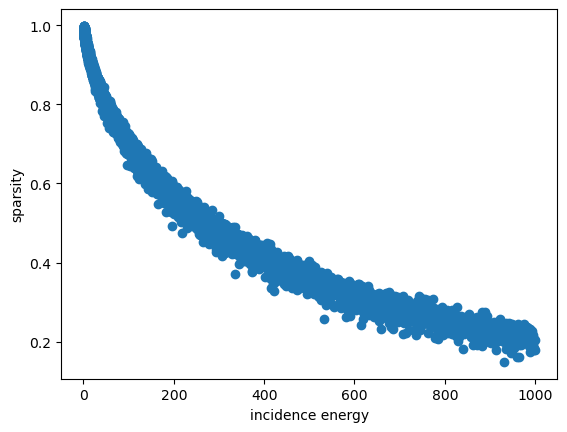

In [48]:
plt.scatter(entarget_samples/1000, (xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1])
plt.xlabel("incidence energy")
plt.ylabel("sparsity")

Text(0, 0.5, 'sparsity')

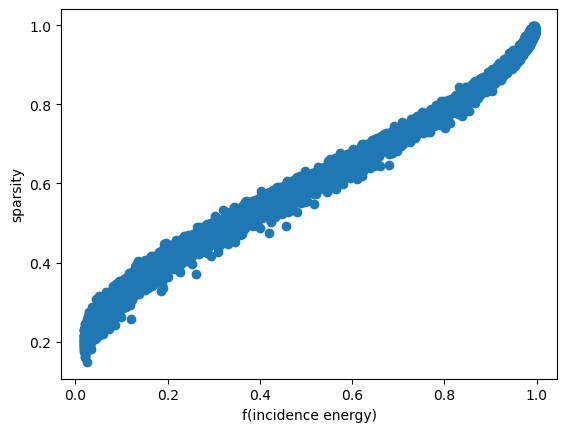

In [52]:
plt.scatter(entarget_samples.divide(1000).multiply(-0.004).exp(), (xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1])
plt.xlabel("f(incidence energy)")
plt.ylabel("sparsity")
